<a href="https://colab.research.google.com/github/antoniovfonseca/summarize-change-components/blob/main/summarize_change_components_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1.Environment Setup**


---



### **1.1.Install Python Libraries**
Run the cell below only if using Google Colab.


In [ ]:
%pip -q install \
    rasterio \
    seaborn \
    xlsxwriter \
    matplotlib-scalebar \
    matplotlib-map-utils

### **1.2.Importing Libraries**

In [1]:
# Standard library
import glob
import os
import pickle
import sys
import time
import math
from pathlib import Path

# Typing for annotations
from typing import Dict, List, Optional, Iterable, Tuple

# Third-party
import numba as nb
import numpy as np
import pandas as pd
import rasterio
import xlsxwriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
from numba import prange
from pyproj import Transformer
from pyproj import Geod
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Rasterio submodules
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling

# Matplotlib extensions
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow
from matplotlib.colors import (
    ListedColormap,
    BoundaryNorm,
    Normalize,
    LinearSegmentedColormap,
)
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

### **1.3.Mounting Google Drive in Colab**
Run the cell below only if using Google Colab.



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

## **2.Data Preparation**

In [2]:
import os

# 1) Define the specific output path for toy data
# Using the path provided for your local environment
output_path = os.path.expanduser(
    "/Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/input_toydata2",
)

# 2) Create the directory structure if it does not exist
if not os.path.exists(
    output_path,
):
    os.makedirs(
        output_path,
    )

print(
    f"Output directory initialized at: {output_path}",
)

Output directory initialized at: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/input_toydata2


### **2.1.Setting Paths to Image Files**

The user must include the year in the raster map name.

In [4]:
import os
import numpy as np
import rasterio
from rasterio.transform import from_origin

# 1) Define the specific output path
output_path = os.path.expanduser(
    "/Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2",
)

# 2) Create the directory structure
os.makedirs(
    output_path,
    exist_ok=True,
)

# 3) Define toy data values (Rows = Time Points, Columns = Pixels)
# Values represent Classes: A=1, B=2, C=3, D=4, E=5
toy_values = np.array(
    [
        [1, 2, 1, 3, 4],  # time_0: P1=A, P2=B, P3=A, P4=C, P5=D
        [1, 2, 2, 2, 3],  # time_1: P1=A, P2=B, P3=B, P4=B, P5=C
        [2, 3, 3, 1, 4]   # time_2: P1=B, P2=C, P3=C, P4=A, P5=D
    ],
    dtype="uint8",
)

years = [
    "time_0",
    "time_1",
    "time_2",
]

# 4) Setup raster metadata (1 row height, 5 columns width)
width = 5
height = 1
transform = from_origin(
    0,
    0,
    1,
    1,
)

toy_input_dir = os.path.join(
    output_path,
    "input_rasters",
)
os.makedirs(
    toy_input_dir,
    exist_ok=True,
)

image_paths = []

# 5) Save each time point as a GeoTIFF
for idx, t_name in enumerate(
    years,
):
    file_path = os.path.join(
        toy_input_dir,
        f"{t_name}.tif",
    )
    
    # Reshape the 1D pixel row to 2D (1, 3)
    data_2d = toy_values[idx].reshape(
        (
            height,
            width,
        ),
    )
    
    with rasterio.open(
        file_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=data_2d.dtype,
        crs="EPSG:4326",
        transform=transform,
        nodata=255,
    ) as dst:
        dst.write(
            data_2d,
            1,
        )
    
    image_paths.append(
        file_path,
    )

# 6) Define mask_path to be the first image to satisfy notebook dependencies
mask_path = image_paths[0]

noData_value = 255

print(
    f"Toy data created. Pixel 1 (A->B->C), Pixel 2 (C->B->A), Pixel 3 (D->E->D).",
)

Toy data created. Pixel 1 (A->B->C), Pixel 2 (C->B->A), Pixel 3 (D->E->D).


/Users/antoniofonseca/miniconda3/envs/geo/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [5]:
# Map integer values to class names A, B, C, D, E
class_labels_dict = {
    1: {
        "name": "Class A",
        "color": "#1f77b4",
    },
    2: {
        "name": "Class B",
        "color": "#ff7f0e",
    },
    3: {
        "name": "Class C",
        "color": "#2ca02c",
    },
    4: {
        "name": "Class D",
        "color": "#d62728",
    },
    # 5: {
    #     "name": "Class E",
    #     "color": "#9467bd",
    # },
}

# Generate list of class names for the analysis functions
class_names = [
    info["name"]
    for class_id, info in sorted(
        class_labels_dict.items(),
    )
]

print(
    f"Processing labels: {class_names}",
)

Processing labels: ['Class A', 'Class B', 'Class C', 'Class D']


In [ ]:
# List of input raster paths
image_paths = [
    r"/home/antfonseca/data/vcr/vcr_1989.tif",
    r"/home/antfonseca/data/vcr/vcr_1990.tif",
    r"/home/antfonseca/data/vcr/vcr_1991.tif",
    r"/home/antfonseca/data/vcr/vcr_1992.tif",
    r"/home/antfonseca/data/vcr/vcr_1993.tif",
    r"/home/antfonseca/data/vcr/vcr_1994.tif",
    r"/home/antfonseca/data/vcr/vcr_1995.tif",
    r"/home/antfonseca/data/vcr/vcr_1996.tif",
    r"/home/antfonseca/data/vcr/vcr_1997.tif",
    r"/home/antfonseca/data/vcr/vcr_1998.tif",
    r"/home/antfonseca/data/vcr/vcr_1999.tif",
    r"/home/antfonseca/data/vcr/vcr_2000.tif",
    r"/home/antfonseca/data/vcr/vcr_2001.tif",
    r"/home/antfonseca/data/vcr/vcr_2002.tif",
    r"/home/antfonseca/data/vcr/vcr_2003.tif",
    r"/home/antfonseca/data/vcr/vcr_2004.tif",
    r"/home/antfonseca/data/vcr/vcr_2005.tif",
    r"/home/antfonseca/data/vcr/vcr_2006.tif",
    r"/home/antfonseca/data/vcr/vcr_2007.tif",
    r"/home/antfonseca/data/vcr/vcr_2008.tif",
    r"/home/antfonseca/data/vcr/vcr_2009.tif",
    r"/home/antfonseca/data/vcr/vcr_2010.tif",
    r"/home/antfonseca/data/vcr/vcr_2011.tif",
    r"/home/antfonseca/data/vcr/vcr_2012.tif",
    r"/home/antfonseca/data/vcr/vcr_2013.tif",
    r"/home/antfonseca/data/vcr/vcr_2014.tif",
    r"/home/antfonseca/data/vcr/vcr_2015.tif",
    r"/home/antfonseca/data/vcr/vcr_2016.tif",
    r"/home/antfonseca/data/vcr/vcr_2017.tif",
    r"/home/antfonseca/data/vcr/vcr_2018.tif",
    r"/home/antfonseca/data/vcr/vcr_2019.tif",
    r"/home/antfonseca/data/vcr/vcr_2020.tif",
    r"/home/antfonseca/data/vcr/vcr_2021.tif"
]

noData_value = 255

# Raster mask path
mask_path = None

# Check if all files exist
all_files = image_paths.copy()

if mask_path is not None:
    all_files.append(mask_path)

missing_files = [f for f in all_files if not os.path.exists(f)]

if missing_files:
    print("Missing files:")
    for f in missing_files:
        print(" -", f)
else:
    print("All input files found.")

### **2.2.Setting Path to Output Files**

In [ ]:
# Output directory path
output_path = r"/home/antfonseca/output/vcr"

# Create folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created:", output_path)
else:
    print("Folder already exists:", output_path)

### **2.3.Setting Years of the Time Intervals**

In [ ]:
# Years of input rasters
years = list(range(1985, 2022))

### **2.4.Setting the classes**

In [ ]:
# Class ID, names, and colors
class_labels_dict = {
     0: {"name": "No Data",   "color": "#d870b2"},
     1: {"name": "Water",     "color": "#003ba1"},
     2: {"name": "Shrubs",    "color": "#c9cc3f"},
     3: {"name": "Tidal flat","color": "#c9712b"},
     4: {"name": "Low marsh", "color": "#ffd700"},
     5: {"name": "High marsh","color": "#6b6e7c"},
     6: {"name": "Barren",    "color": "#ffdead"},
     7: {"name": "Tree",      "color": "#228b22"}
}

# Sorted list of renamed class labels
class_labels = [class_labels_dict[key]["name"] for key in sorted(class_labels_dict.keys())]

### **2.4.Apply Mask**
The function applies a binary mask to the input rasters, keeping only the pixels where the mask value equals 1 and setting the others to 0. It then converts the data to 8-bit format and saves the results as LZW-compressed TIFF files.

In [5]:
def apply_mask_to_images(image_paths, output_path, mask_path=None):
    """
    Apply a mask to raster images and save as 8-bit TIFFs.

    Args:
        image_paths (list[str]): Paths to input images.
        output_path (str): Directory to save masked images.
        mask_path (str, optional): Path to mask raster.

    Returns:
        list[str]: Paths to saved masked images.
    """
    # Create output folder if missing
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    saved_paths = []

    # Load mask if provided
    mask_data = None
    if mask_path:
        with rasterio.open(mask_path) as mask_file:
            mask_data = mask_file.read(1)

    # Apply mask to each image
    for path in image_paths:
        with rasterio.open(path) as image:
            meta = image.meta.copy()

            # Force 8-bit TIFF settings
            meta["dtype"] = "uint8"
            meta["nodata"] = 255
            meta["driver"] = "GTiff"
            meta["compress"] = "lzw"

            # Read raster band and apply mask
            image_data = image.read(1)
            if mask_data is not None:
                masked_data = (image_data * (mask_data == 1)).astype("uint8")
            else:
                masked_data = image_data.astype("uint8")

            # Build output path
            base_name = os.path.basename(path).replace(".tif", "_masked.tif")
            masked_path = os.path.join(output_path, base_name)

            # Save masked image
            with rasterio.open(masked_path, "w", **meta) as dest:
                dest.write(masked_data, 1)

            saved_paths.append(masked_path)

    return saved_paths


# Apply mask and save results
masked_image_paths = apply_mask_to_images(
    image_paths,
    output_path,
    mask_path
)

# Print saved paths
for path in masked_image_paths:
    print(path)

/Users/antoniofonseca/Dataset/toydata/toydata1/time_0_masked.tif
/Users/antoniofonseca/Dataset/toydata/toydata1/time_1_masked.tif
/Users/antoniofonseca/Dataset/toydata/toydata1/time_2_masked.tif


### **2.5.Display the Maps**

The code defines a function to find files with a given suffix and returns their paths. It then defines a function that plots each raster file with a specified color map, and a legend. It reads the raster data with rasterio, reshapes it, applies the color map, and arranges the images in a single row of subplots. It sets each plot’s title with the provided year, hides the axes, and includes a custom legend. Finally, it saves the plot as a JPEG and displays it.

In [ ]:
def compute_display_pixel_size_km(
    raster_path: str,
    downsample_divisor: int,
) -> float:
    """
    Compute horizontal resolution in kilometers per displayed pixel.

    Parameters
    ----------
    raster_path : str
        Path to a raster file used to derive spatial extent and CRS.
    downsample_divisor : int
        Integer factor used to downsample the raster width for display.

    Returns
    -------
    float
        Pixel size in kilometers for the downsampled display grid.
    """

    with rasterio.open(raster_path) as src:
        left, bottom, right, top = src.bounds
        lat_mid_src = (top + bottom) / 2.0

        to_ll = Transformer.from_crs(
            src.crs,
            "EPSG:4326",
            always_xy=True,
        )
        lon_l, lat_mid = to_ll.transform(
            left,
            lat_mid_src,
        )
        lon_r, _ = to_ll.transform(
            right,
            lat_mid_src,
        )

        geod = Geod(
            ellps="WGS84",
        )
        _, _, width_m = geod.inv(
            lon_l,
            lat_mid,
            lon_r,
            lat_mid,
        )

        cols_disp = max(
            1,
            src.width // downsample_divisor,
        )

        return (width_m / cols_disp) / 1_000


def plot_classified_images(
    class_map: Dict[int, Dict[str, str]],
    years: List[int],
    output_path: str,
    downsample_divisor: int = 1,
    panel_size: tuple = (4.0, 6.0),
    dx_km: Optional[float] = None,
    resampling_method: Resampling = Resampling.bilinear,
) -> None:
    """
    Plot classified rasters over time with legend, north arrow, and scale bar.

    Parameters
    ----------
    class_map : Dict[int, Dict[str, str]]
        Mapping from class ID to metadata with at least
        ``{"name": str, "color": str}`` for each class.
    years : List[int]
        List of years corresponding to each classified raster.
    output_path : str
        Directory where input rasters are stored and the figure is saved.
    downsample_divisor : int, optional
        Factor used to downsample raster dimensions for display, by default 1.
    panel_size : tuple, optional
        Width and height in inches for a single panel, by default (4.0, 6.0).
    dx_km : float, optional
        Pixel size in kilometers for the scale bar. If None, it is computed
        from the first raster, by default None.
    resampling_method : Resampling, optional
        Resampling method used when reading rasters, by default
        ``Resampling.bilinear``.

    Returns
    -------
    None
        This function saves a multi-panel figure to disk and shows the plot.
    """

    image_paths = sorted(
        glob.glob(
            os.path.join(
                output_path,
                "*masked.tif",
            ),
        ),
    )

    if not image_paths:
        raise ValueError("image_paths is empty.")

    if len(image_paths) != len(years):
        raise ValueError("image_paths and years must match in length.")

    # Configure subplot grid with a maximum number of columns.
    n_images = len(image_paths)
    max_cols = 10
    ncols = min(
        max_cols,
        n_images,
    )
    nrows = math.ceil(n_images / max_cols)

    fig, axs = plt.subplots(
        nrows,
        ncols,
        figsize=(
            panel_size[0] * ncols,
            panel_size[1] * nrows,
        ),
        sharey=True,
        constrained_layout=False,
    )
    plt.subplots_adjust(
        left=0.02,
        right=0.85,
        top=0.95,
        bottom=0.05,
        wspace=0.04,
        hspace=0.04,
    )

    if isinstance(axs, np.ndarray):
        axes = axs.ravel()
    else:
        axes = [axs]

    # Build colormap and normalization for class IDs.
    class_ids_sorted = sorted(class_map.keys())
    cmap = ListedColormap(
        [
            class_map[k]["color"]
            for k in class_ids_sorted
        ],
    )
    norm = BoundaryNorm(
        class_ids_sorted + [class_ids_sorted[-1] + 1],
        cmap.N,
    )

    # Derive km per displayed pixel when not provided.
    if dx_km is None:
        dx_km = compute_display_pixel_size_km(
            raster_path=image_paths[0],
            downsample_divisor=downsample_divisor,
        )

    # Plot each classified raster in its subplot.
    for i, (path, year) in enumerate(
        zip(
            image_paths,
            years,
        ),
    ):
        ax = axes[i]

        with rasterio.open(path) as src:
            h = max(
                1,
                src.height // downsample_divisor,
            )
            w = max(
                1,
                src.width // downsample_divisor,
            )
            data = src.read(
                1,
                out_shape=(
                    h,
                    w,
                ),
                resampling=resampling_method,
            )

        ax.imshow(
            data,
            cmap=cmap,
            norm=norm,
        )
        ax.set_title(
            f"{year}",
            fontweight="bold",
            fontsize=24,
        )
        ax.axis("off")

    # Disable unused axes when the grid is larger than the number of images.
    for j in range(
        n_images,
        len(axes),
    ):
        axes[j].axis("off")

    # Create legend using all class IDs on the last axis.
    legend_elements = [
        Rectangle(
            (0, 0),
            1,
            1,
            color=class_map[k]["color"],
            label=class_map[k]["name"],
        )
        for k in sorted(class_map.keys())
    ]

    last_ax = axes[n_images - 1]

    last_ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.02,
            0.5,
        ),
        frameon=False,
        fontsize=24,
    )

    # Add scale bar to the last subplot.
    scalebar = ScaleBar(
        dx=dx_km,
        units="km",
        length_fraction=0.35,
        location="lower right",
        scale_loc="bottom",
        color="black",
        box_alpha=0,
    )
    axes[n_images - 1].add_artist(
        scalebar,
    )

    # Add north arrow to the last subplot.
    north_arrow(
        axes[n_images - 1],
        location="upper left",
        shadow=False,
        rotation={
            "degrees": 0,
        },
    )

    # Save figure to disk.
    out_fig = os.path.join(
        output_path,
        "plot_input_maps.jpeg",
    )
    plt.savefig(
        out_fig,
        format="jpeg",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()
    plt.close()

plot_classified_images(
    class_map=class_labels_dict,
    years=years,
    output_path=output_path,
)

## **3.Class distribution over time**


---


Pixel counts per time point and class:
ClassName  Class A  Class B  Class C  Class D
Year                                         
time_0         2.0      1.0      1.0      1.0
time_1         1.0      3.0      1.0      0.0
time_2         1.0      1.0      2.0      1.0


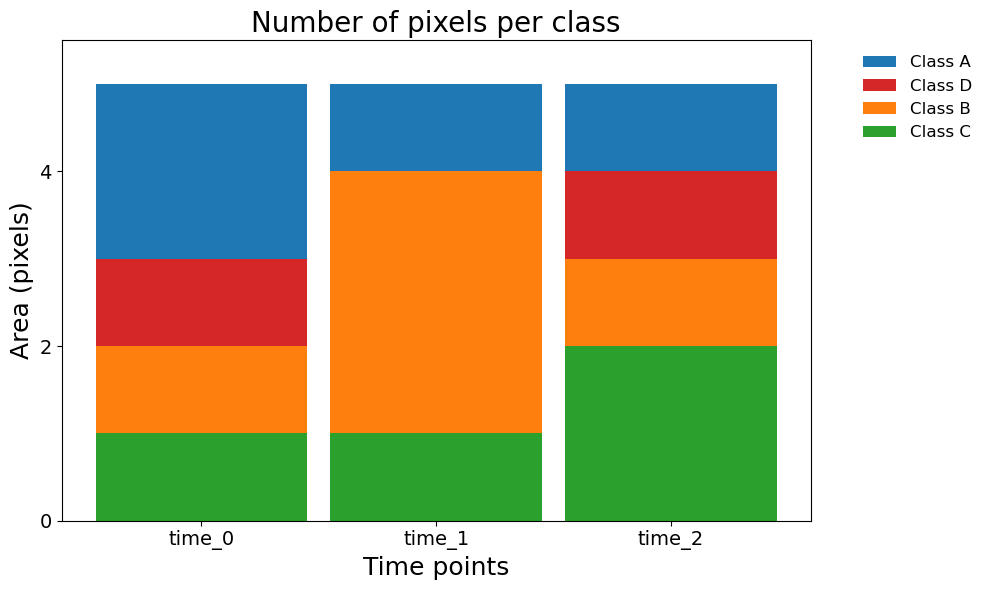

In [6]:
# Collect masked rasters
import glob
import os

# Adjusting to find the correct files in the input folder
image_paths = sorted(
    glob.glob(
        os.path.join(
            output_path,
            "input_rasters",
            "time_*.tif",
        ),
    ),
)

# Re-run the rest of your plotting code

if len(image_paths) != len(years):
    raise ValueError(
        f"Found {len(image_paths)} masked rasters but len(years) == {len(years)}.",
    )

records: list[dict] = []

# Count pixels per class (excluding 0 / Background) for each year
for year, path in zip(
    years,
    image_paths,
):
    with rasterio.open(
        path,
    ) as src:
        data = src.read(
            1,
        )

    values, counts = np.unique(
        data,
        return_counts=True,
    )

    for value, count in zip(
        values,
        counts,
    ):
        value = int(value)
        # if value == 0:
        #     continue
        if value not in class_labels_dict:
            continue

        records.append(
            {
                "Year": year,
                "ClassID": value,
                "ClassName": class_labels_dict[value]["name"],
                "Pixels": int(count),
            },
        )

df_pixels = pd.DataFrame(
    records,
)

# Pivot table: rows = years, columns = classes, values = pixel counts
pivot_pixels = (
    df_pixels.pivot_table(
        index="Year",
        columns="ClassName",
        values="Pixels",
        aggfunc="sum",
    )
    .fillna(0.0)
    .astype(float)
)

years_array = pivot_pixels.index.values

# Automatic scale for y-axis
max_val = pivot_pixels.to_numpy().max()

if max_val >= 1_000_000:
    scale_factor = 1_000_000
    y_label = "Area (million pixels)"
elif max_val >= 1_000:
    scale_factor = 1_000
    y_label = "Area (thousand pixels)"
elif max_val >= 100:
    scale_factor = 100
    y_label = "Area (hundred pixels)"
else:
    scale_factor = 1
    y_label = "Area (pixels)"

pivot_scaled = pivot_pixels / scale_factor

# Print the counts to the console to verify the 3 pixels
print(
    "Pixel counts per time point and class:",
)
print(
    pivot_pixels,
)

# # Class IDs and color map
# class_ids_plot = [
#     class_id
#     for class_id in sorted(class_labels_dict.keys())
#     if class_id != 0
# ]

# Class IDs and color map
class_ids_plot = sorted(
    class_labels_dict.keys(),
)

color_map = {
    class_labels_dict[class_id]["name"]: class_labels_dict[class_id]["color"]
    for class_id in class_ids_plot
}

# Sort classes by net change (last - first)
first_year = years_array[0]
last_year = years_array[-1]

net_change_per_class = (
    pivot_scaled.loc[last_year]
    - pivot_scaled.loc[first_year]
)

# Order for stacking:
#   bottom = largest gainers, top = largest losers
classes_for_stack = list(
    net_change_per_class.sort_values(
        ascending=False,
    ).index,
)

# Order for legend:
#   top = largest losers, bottom = largest gainers
classes_for_legend = list(
    reversed(classes_for_stack),
)

# Stacked bar chart
fig, ax = plt.subplots(
    figsize=(
        10,
        6,
    ),
)

x = np.arange(
    len(years_array),
)
width = 0.9

base = np.zeros(
    len(years_array),
    dtype=float,
)

patches_by_class: dict[str, plt.Artist] = {}

for cls in classes_for_stack:
    if cls not in pivot_scaled.columns:
        continue

    values_cls = pivot_scaled[cls].reindex(
        years_array,
        fill_value=0.0,
    ).values

    bars = ax.bar(
        x,
        values_cls,
        bottom=base,
        width=width,
        label=cls,
        color=color_map[cls],
    )
    patches_by_class[cls] = bars[0]
    base += values_cls

# X-axis ticks and adaptive rotation
ax.set_xticks(
    x,
)
ax.set_xticklabels(
    years_array,
)
n_labels = len(years_array)
if n_labels <= 6:
    rotation = 0
    ha = "center"
elif n_labels <= 12:
    rotation = 45
    ha = "right"
else:
    rotation = 90
    ha = "center"

plt.setp(
    ax.get_xticklabels(),
    rotation=rotation,
    ha=ha,
)

ax.tick_params(
    axis="both",
    labelsize=14,
)

ax.set_ylabel(
    y_label,
    fontsize=18,
)
ax.set_xlabel(
    "Time points",
    fontsize=18,
)
ax.set_title(
    "Number of pixels per class",
    fontsize=20,
)

# Y-axis limit based on stacked maximum
y_max_scaled = base.max() * 1.1 if base.max() > 0 else 1.0
ax.set_ylim(
    0,
    y_max_scaled,
)
ax.yaxis.set_major_locator(
    ticker.MaxNLocator(
        nbins=5,
        integer=True,

    ),
)

ax.yaxis.set_major_formatter(
    ticker.FormatStrFormatter(
        "%d",
    ),
)

# Legend: largest losers at the top, largest gainers at the bottom
handles = [
    patches_by_class[cls]
    for cls in classes_for_legend
    if cls in patches_by_class
]
labels = [
    cls
    for cls in classes_for_legend
    if cls in patches_by_class
]

ax.legend(
    handles,
    labels,
    bbox_to_anchor=(
        1.05,
        1.0,
    ),
    loc="upper left",
    frameon=False,
    fontsize=12,
)

plt.tight_layout()
plt.show()

In [7]:
# Export pixel counts per time point to CSV
csv_output_path = os.path.join(
    output_path,
    "pixels_per_class_per_year.csv",
)

pivot_pixels.to_csv(
    csv_output_path,
    index_label="Year",
)

print(
    f"Pixel counts table saved to: {csv_output_path}",
)

Pixel counts table saved to: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/pixels_per_class_per_year.csv


## **4.Generate the Transition Matrix**


---
In this section, the computer code will generate four different transition matrices. The first one is related to each time interval. The second one is the transition matrix for the temporal extent, which is represented for the first and last time point of the time extent. The third one is a transition matrix that represents the sum of all time intervals. And the last transition matrix is the alternation matrix, which is the sum matrix minus the extent matrix.

Before generate the transition matrix, the computer code will analyze the presence of 0, NULL and NA value in all maps. If there is a presence of one of these values, the computer code will create a mask with these values and will remove all the pixels in the same position in all maps and years.

All the transition matrix will be salved in yput output folder in the ".csv" format.

In [8]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from typing import List, Tuple

# 1) Define the correct path for toy data rasters
input_rasters_path = os.path.join(
    output_path,
    "input_rasters",
)

def generate_mask_and_flatten_rasters(
    output_path: str,
    suffix: str = ".tif",
) -> Tuple[List[np.ndarray], List[int]]:
    """
    Read rasters by suffix, mask zeros/NaN/nodata, and flatten valid values.

    Parameters
    ----------
    output_path : str
        Folder containing rasters.
    suffix : str, optional
        Filename suffix to select rasters, by default ".tif".

    Returns
    -------
    Tuple[List[np.ndarray], List[int]]
        List of flattened arrays and list of corresponding years.
    """
    search_pattern = os.path.join(
        output_path,
        f"*{suffix}",
    )
    image_paths = sorted(
        glob.glob(
            search_pattern,
        ),
    )

    if not image_paths:
        raise FileNotFoundError(
            f"No files found with suffix {suffix} in {output_path}",
        )

    all_data: List[np.ndarray] = []
    all_masks: List[np.ndarray] = []
    years: List[int] = []

    for path in tqdm(
        image_paths,
        desc="Reading and masking rasters",
        unit="raster",
    ):
        year_match = re.search(
            r"(\d+)",
            os.path.basename(path),
        )
        years.append(
            int(year_match.group(1)) if year_match else 0,
        )

        with rasterio.open(
            path,
        ) as src:
            data = src.read(
                1,
            )
            mask = (
                (data == 255)
                | (data == src.nodata)
                | np.isnan(data.astype(float))
            )
            all_masks.append(
                mask,
            )
            all_data.append(
                data,
            )

    combined_mask = np.any(
        all_masks,
        axis=0,
    )

    flattened = [
        data[~combined_mask].flatten() if np.any(combined_mask) else data.flatten()
        for data in all_data
    ]

    return flattened, years


def generate_all_matrices(
    input_path: str,
    output_path: str,
    suffix: str = ".tif",
) -> tuple:
    """
    Generate transition matrices using Hybrid Decomposition logic.
    
    Logic:
    1. Extent: Decomposed Aggregately (Pontius Slide 4).
       Captures swaps between different pixels (e.g., A->C and C->A).
    2. Alternation: Decomposed Per-Pixel (Pontius Slide 9 & 10).
       Preserves trajectory identity (e.g., A->B->C is Shift, not Exchange).
    """
    # 1. Load data
    flattened_data, years = generate_mask_and_flatten_rasters(
        input_path, 
        suffix,
    )
    
    all_classes = np.unique(
        np.concatenate(
            flattened_data,
        ),
    ).astype(int)
    
    n = len(all_classes)
    class_to_idx = {
        cls: i 
        for i, cls in enumerate(all_classes)
    }

    # Initialize matrices
    mat_sum = np.zeros(
        (n, n),
    )
    mat_ext = np.zeros(
        (n, n),
    )
    mat_ax = np.zeros(
        (n, n),
    )
    mat_as = np.zeros(
        (n, n),
    )
    
    interval_matrices = {
        f"{years[t]}-{years[t+1]}": np.zeros((n, n)) 
        for t in range(len(years) - 1)
    }

    # 2. Pixel-level Processing
    num_pixels = len(
        flattened_data[0],
    )
    
    for r in range(
        num_pixels,
    ):
        traj = [
            int(flattened_data[t][r]) 
            for t in range(len(flattened_data))
        ]
        start_idx = class_to_idx[
            traj[0]
        ]
        end_idx = class_to_idx[
            traj[-1]
        ]

        # Individual Pixel Matrices
        m_r = np.zeros(
            (n, n),
        )
        for t in range(
            len(traj) - 1,
        ):
            s = class_to_idx[
                traj[t]
            ]
            e = class_to_idx[
                traj[t+1]
            ]
            m_r[
                s, 
                e,
            ] += 1
            interval_matrices[
                f"{years[t]}-{years[t+1]}"
            ][
                s, 
                e,
            ] += 1
        
        e_r = np.zeros(
            (n, n),
        )
        e_r[
            start_idx, 
            end_idx,
        ] += 1
        
        # Accumulate Aggregates
        mat_sum += m_r
        mat_ext += e_r

        # --- PIXEL-LEVEL DECOMPOSITION FOR ALTERNATION ---
        # Eq 4 applied per pixel: A_r = M_r - E_r
        a_r = m_r - e_r
        
        # Eq 5 applied per pixel: Ax_r = min(A_r, A_r.T)
        # We clamp to 0 to ensure Exchange is strictly positive gain
        ax_r = np.maximum(
            0, 
            np.minimum(
                a_r, 
                a_r.T,
            ),
        )
        
        # Eq 6 applied per pixel: As_r = A_r - Ax_r
        as_r = a_r - ax_r
        
        # Accumulate the decomposed alternation components
        mat_ax += ax_r
        mat_as += as_r

    # 3. Aggregate Decomposition for Extent (Eq 1 & 2)
    # Applied on the total Extent matrix to capture inter-pixel swaps
    mat_ex = np.maximum(
        0, 
        np.minimum(
            mat_ext, 
            mat_ext.T,
        ),
    )
    mat_es = mat_ext - mat_ex

    # 4. Save matrices
    
    # A) Save individual intervals
    for interval_name, mat in interval_matrices.items():
        fname = f"transition_matrix_{interval_name}.csv"
        out_csv = os.path.join(
            output_path, 
            fname,
        )
        pd.DataFrame(
            mat, 
            index=all_classes, 
            columns=all_classes,
        ).to_csv(out_csv)

    # B) Save aggregated components
    interval_str = f"{years[0]}-{years[-1]}"
    aggregated = {
        "sum": mat_sum,
        "extent": mat_ext,
        "extent_exchange": mat_ex,
        "extent_shift": mat_es,
        "alternation_exchange": mat_ax,
        "alternation_shift": mat_as,
    }
    
    for name, mat in aggregated.items():
        fname = f"transition_matrix_{name}_{interval_str}.csv"
        out_csv = os.path.join(
            output_path, 
            fname,
        )
        pd.DataFrame(
            mat, 
            index=all_classes, 
            columns=all_classes,
        ).to_csv(out_csv)

    return years, all_classes

# Execution
print(
    "Generating matrices...",
)
years_out, all_classes = generate_all_matrices(
    input_path=input_rasters_path,
    output_path=output_path,
    suffix=".tif",
)
print(
    f"Success. Files saved with suffix: {years_out[0]}-{years_out[-1]}",
)

Generating matrices...


Reading and masking rasters: 100%|███████████████████████████████| 3/3 [00:00<00:00, 454.82raster/s]

Success. Files saved with suffix: 0-2


### New Transition Matrix

In [9]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from typing import List, Tuple

# 1) Define the correct path for toy data rasters
input_rasters_path = os.path.join(
    output_path,
    "input_rasters",
)

def generate_mask_and_flatten_rasters(
    output_path: str,
    suffix: str = ".tif",
) -> Tuple[List[np.ndarray], List[int]]:
    """
    Read rasters by suffix, mask zeros/NaN/nodata, and flatten valid values.

    Parameters
    ----------
    output_path : str
        Folder containing rasters.
    suffix : str, optional
        Filename suffix to select rasters, by default ".tif".

    Returns
    -------
    Tuple[List[np.ndarray], List[int]]
        List of flattened arrays and list of corresponding years.
    """
    search_pattern = os.path.join(
        output_path,
        f"*{suffix}",
    )
    image_paths = sorted(
        glob.glob(
            search_pattern,
        ),
    )

    if not image_paths:
        raise FileNotFoundError(
            f"No files found with suffix {suffix} in {output_path}",
        )

    all_data: List[np.ndarray] = []
    all_masks: List[np.ndarray] = []
    years: List[int] = []

    for path in tqdm(
        image_paths,
        desc="Reading and masking rasters",
        unit="raster",
    ):
        year_match = re.search(
            r"(\d+)",
            os.path.basename(path),
        )
        years.append(
            int(year_match.group(1)) if year_match else 0,
        )

        with rasterio.open(
            path,
        ) as src:
            data = src.read(
                1,
            )
            mask = (
                (data == 255)
                | (data == src.nodata)
                | np.isnan(data.astype(float))
            )
            all_masks.append(
                mask,
            )
            all_data.append(
                data,
            )

    combined_mask = np.any(
        all_masks,
        axis=0,
    )

    flattened = [
        data[~combined_mask].flatten() if np.any(combined_mask) else data.flatten()
        for data in all_data
    ]

    return flattened, years


def generate_all_matrices(
    input_path: str,
    output_path: str,
    suffix: str = ".tif",
) -> tuple:
    """
    Generate transition matrices using Hybrid Decomposition logic.
    
    Logic:
    1. Extent: Decomposed Aggregately (Pontius Slide 4).
       Captures swaps between different pixels (e.g., A->C and C->A).
    2. Alternation: Decomposed Per-Pixel (Pontius Slide 9 & 10).
       Preserves trajectory identity (e.g., A->B->C is Shift, not Exchange).
    """
    # 1. Load data
    flattened_data, years = generate_mask_and_flatten_rasters(
        input_path, 
        suffix,
    )
    
    all_classes = np.unique(
        np.concatenate(
            flattened_data,
        ),
    ).astype(int)
    
    n = len(all_classes)
    class_to_idx = {
        cls: i 
        for i, cls in enumerate(all_classes)
    }

    # Initialize matrices
    mat_sum = np.zeros(
        (n, n),
    )
    mat_ext = np.zeros(
        (n, n),
    )
    mat_ax = np.zeros(
        (n, n),
    )
    mat_as = np.zeros(
        (n, n),
    )
    
    interval_matrices = {
        f"{years[t]}-{years[t+1]}": np.zeros((n, n)) 
        for t in range(len(years) - 1)
    }

    # 2. Pixel-level Processing
    num_pixels = len(
        flattened_data[0],
    )
    
    for r in range(
        num_pixels,
    ):
        traj = [
            int(flattened_data[t][r]) 
            for t in range(len(flattened_data))
        ]
        start_idx = class_to_idx[
            traj[0]
        ]
        end_idx = class_to_idx[
            traj[-1]
        ]

        # Individual Pixel Matrices
        m_r = np.zeros(
            (n, n),
        )
        for t in range(
            len(traj) - 1,
        ):
            s = class_to_idx[
                traj[t]
            ]
            e = class_to_idx[
                traj[t+1]
            ]
            m_r[
                s, 
                e,
            ] += 1
            interval_matrices[
                f"{years[t]}-{years[t+1]}"
            ][
                s, 
                e,
            ] += 1
        
        e_r = np.zeros(
            (n, n),
        )
        e_r[
            start_idx, 
            end_idx,
        ] += 1
        
        # Accumulate Aggregates
        mat_sum += m_r
        mat_ext += e_r

        # --- PIXEL-LEVEL DECOMPOSITION FOR ALTERNATION ---
        # Eq 4 applied per pixel: A_r = M_r - E_r
        a_r = m_r - e_r
        
        # Eq 5 applied per pixel: Ax_r = min(A_r, A_r.T)
        # We clamp to 0 to ensure Exchange is strictly positive gain
        ax_r = np.maximum(
            0, 
            np.minimum(
                a_r, 
                a_r.T,
            ),
        )
        
        # Eq 6 applied per pixel: As_r = A_r - Ax_r
        as_r = a_r - ax_r
        
        # Accumulate the decomposed alternation components
        mat_ax += ax_r
        mat_as += as_r

    # 3. Aggregate Decomposition for Extent (Eq 1 & 2)
    # Applied on the total Extent matrix to capture inter-pixel swaps
    mat_ex = np.maximum(
        0, 
        np.minimum(
            mat_ext, 
            mat_ext.T,
        ),
    )
    mat_es = mat_ext - mat_ex

    # 4. Save matrices
    
    # A) Save individual intervals
    for interval_name, mat in interval_matrices.items():
        fname = f"transition_matrix_{interval_name}.csv"
        out_csv = os.path.join(
            output_path, 
            fname,
        )
        pd.DataFrame(
            mat, 
            index=all_classes, 
            columns=all_classes,
        ).to_csv(out_csv)

    # B) Save aggregated components
    interval_str = f"{years[0]}-{years[-1]}"
    aggregated = {
        "sum": mat_sum,
        "extent": mat_ext,
        "extent_exchange": mat_ex,
        "extent_shift": mat_es,
        "alternation_exchange": mat_ax,
        "alternation_shift": mat_as,
    }
    
    for name, mat in aggregated.items():
        fname = f"transition_matrix_{name}_{interval_str}.csv"
        out_csv = os.path.join(
            output_path, 
            fname,
        )
        pd.DataFrame(
            mat, 
            index=all_classes, 
            columns=all_classes,
        ).to_csv(out_csv)

    return years, all_classes

# Execution
print(
    "Generating matrices...",
)
years_out, all_classes = generate_all_matrices(
    input_path=input_rasters_path,
    output_path=output_path,
    suffix=".tif",
)
print(
    f"Success. Files saved with suffix: {years_out[0]}-{years_out[-1]}",
)

Generating matrices...


Reading and masking rasters: 100%|███████████████████████████████| 3/3 [00:00<00:00, 543.49raster/s]

Success. Files saved with suffix: 0-2


## **5.Heat Maps**


---

### 5.1 Functions

In [10]:
# Basic checks for global inputs used in the matrices
assert isinstance(
    years,
    (
        list,
        tuple,
    ),
) and len(years) >= 2, "`years` missing or invalid."

assert isinstance(
    output_path,
    str,
) and output_path, "`output_path` missing or invalid."

assert isinstance(
    class_labels_dict,
    dict,
) and class_labels_dict, "`class_labels_dict` missing or invalid."

Y0, Y1 = years[0], years[-1]
OUT_DIR = Path(output_path)

CSV_SUM = OUT_DIR / f"transition_matrix_sum_{Y0}-{Y1}.csv"
CSV_EXT = OUT_DIR / f"transition_matrix_extent_{Y0}-{Y1}.csv"
CSV_ALT = OUT_DIR / f"transition_matrix_alternation_{Y0}-{Y1}.csv"
CSV_EXC = OUT_DIR / f"transition_matrix_exchange_FROM_SUM_{Y0}-{Y1}.csv"

for path_csv in (
    CSV_SUM,
    CSV_EXT,
    CSV_ALT,
):
    if not path_csv.exists():
        raise FileNotFoundError(
            f"Missing CSV: {path_csv}",
        )

print("Found base CSVs.")


def load_square_matrix(
    csv_path: Path,
) -> pd.DataFrame:
    """
    Load a square transition matrix from CSV and align row/column labels.

    Parameters
    ----------
    csv_path : Path
        Path to a CSV file where the first column and the header row
        contain class IDs (or labels), and the remaining cells contain
        transition counts.

    Returns
    -------
    pd.DataFrame
        Square DataFrame with string labels on both rows and columns.
        When row and column labels differ, their union is used and
        missing cells are filled with 0.0.
    """
    df = pd.read_csv(
        csv_path,
        index_col=0,
    )
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)

    if list(df.index) != list(df.columns):
        labels = sorted(
            set(df.index).union(df.columns),
            key=lambda x: int(x),
        )
        df = df.reindex(
            index=labels,
            columns=labels,
        ).fillna(0.0)

    if df.shape[0] != df.shape[1]:
        raise ValueError(
            f"Matrix not square after alignment: {csv_path}",
        )

    return df


def label_id_to_name(
    labels: Iterable[str],
) -> list[str]:
    """
    Map class ID strings to human-readable names using ``class_labels_dict``.

    Parameters
    ----------
    labels : iterable of str
        Class IDs as strings (e.g. ``["0", "1", "2"]``) taken from
        matrix indices or columns.

    Returns
    -------
    list of str
        List of class names where each ID is mapped to:
        ``class_labels_dict[id]["rename"]`` if present,
        otherwise ``class_labels_dict[id]["name"]``, and finally
        the original ID string if the ID is not found.
    """
    id_to_name = {
        int(k): v.get(
            "rename",
            v.get(
                "name",
                str(k),
            ),
        )
        for k, v in class_labels_dict.items()
    }

    names: list[str] = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(
                id_to_name.get(
                    cid,
                    str(lab),
                ),
            )
        except Exception:
            names.append(str(lab))

    return names


def exchange_from_T(
    dfT: pd.DataFrame,
) -> pd.DataFrame:
    """
    Compute the bilateral exchange matrix from a transition matrix.

    Parameters
    ----------
    dfT : pd.DataFrame
        Square transition matrix where ``T_ij`` is the number of pixels
        transitioning from class ``i`` (row) to class ``j`` (column).

    Returns
    -------
    pd.DataFrame
        Square exchange matrix ``E`` with the same index/columns as
        ``dfT``, where::

            E(i, j) = min(T_ij, T_ji)  for i != j
            E(i, i) = 0
    """
    T = dfT.values.astype(float)
    E = np.minimum(
        T,
        T.T,
    )
    np.fill_diagonal(
        E,
        0.0,
    )

    return pd.DataFrame(
        E,
        index=dfT.index,
        columns=dfT.columns,
    )


def compute_net_change_from_sum(
    df_sum: pd.DataFrame,
) -> pd.Series:
    """
    Compute net change per class from a SUM transition matrix.

    Parameters
    ----------
    df_sum : pd.DataFrame
        Square transition matrix representing total transitions over
        the full time span, including persistence on the diagonal.

    Returns
    -------
    pd.Series
        Net change for each class (index aligned with ``df_sum.index``),
        computed as::

            net_change(j) = gains(j) - losses(j)

        where gains(j) is the sum of column j (i -> j) excluding the
        diagonal, and losses(j) is the sum of row j (j -> k) excluding
        the diagonal.
    """
    M = df_sum.values.astype(float).copy()

    # Remove persistence on the diagonal for the calculation
    np.fill_diagonal(
        M,
        0.0,
    )

    gains = M.sum(
        axis=0,
    )
    losses = M.sum(
        axis=1,
    )

    net_change = gains - losses

    return pd.Series(
        net_change,
        index=df_sum.index,
    )


def reorder_matrices_by_net_change(
    df_sum: pd.DataFrame,
    df_ext: pd.DataFrame,
    df_alt: pd.DataFrame,
    df_exc: pd.DataFrame,
) -> tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
]:
    """
    Reorder rows and columns of all matrices using net change from ``df_sum``.

    Parameters
    ----------
    df_sum : pd.DataFrame
        SUM transition matrix.
    df_ext : pd.DataFrame
        Extent matrix for the same classes.
    df_alt : pd.DataFrame
        Alternation matrix for the same classes.
    df_exc : pd.DataFrame
        Exchange matrix (e.g. derived from SUM) for the same classes.

    Returns
    -------
    tuple of pd.DataFrame
        Tuple ``(df_sum_ord, df_ext_ord, df_alt_ord, df_exc_ord)`` where
        all matrices share the same ordering, with:

        - largest losers (most negative net change) at the top,
        - largest gainers (most positive net change) at the bottom.
    """
    net_change = compute_net_change_from_sum(
        df_sum=df_sum,
    )
    order_labels = (
        net_change.sort_values(
            ascending=True,
        )
        .index.tolist()
    )

    def _reorder(
        df: pd.DataFrame,
    ) -> pd.DataFrame:
        return df.reindex(
            index=order_labels,
            columns=order_labels,
        )

    return (
        _reorder(df_sum),
        _reorder(df_ext),
        _reorder(df_alt),
        _reorder(df_exc),
    )


def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
) -> None:
    """
    Annotate a heatmap with integer cell values and adaptive text color.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes object on which the heatmap was drawn.
    M : np.ndarray
        2D array of original (unscaled) values used for annotations.
    fontsize : int, optional
        Font size for the cell labels.

    Notes
    -----
    - Diagonal cells are always annotated in white to contrast with
      the black diagonal fill.
    - Off-diagonal cells with large positive or negative magnitude
      are also annotated in white; thresholds are computed ignoring
      the diagonal.
    """
    if M.size == 0:
        return

    M_off = M.copy()
    np.fill_diagonal(
        M_off,
        np.nan,
    )
    data_off = M_off[np.isfinite(M_off)]

    has_pos = np.any(data_off > 0)
    has_neg = np.any(data_off < 0)

    max_pos = float(np.nanmax(data_off[data_off > 0])) if has_pos else 0.0
    min_neg = float(np.nanmin(data_off[data_off < 0])) if has_neg else 0.0

    thresh_pos = 0.5 * max_pos if has_pos else np.inf
    thresh_neg = 0.5 * min_neg if has_neg else -np.inf

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            v = float(M[i, j])
            txt = f"{int(round(v))}"

            if i == j:
                color = "white"
            else:
                if (
                    has_pos
                    and v >= thresh_pos
                ) or (
                    has_neg
                    and v <= thresh_neg
                ):
                    color = "white"
                else:
                    color = "black"

            ax.text(
                j,
                i,
                txt,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=color,
                clip_on=True,
            )


def _unit_label(
    suffix: str,
    base_label: str = "Number of pixels",
) -> str:
    """
    Build a descriptive label for the colorbar based on a unit suffix.

    Parameters
    ----------
    suffix : str
        Unit suffix, e.g. ``""``, ``"k"``, ``"M"``, ``"B"``, ``"T"``.
    base_label : str, optional
        Base text used when ``suffix == ""``.

    Returns
    -------
    str
        Human-readable label, e.g. ``"Millions of pixels"`` when
        ``suffix == "M"``.
    """
    mapping = {
        "": base_label,
        "k": "Thousands of pixels",
        "M": "Millions of pixels",
        "B": "Billions of pixels",
        "T": "Trillions of pixels",
    }

    return mapping.get(
        suffix,
        f"{base_label} ({suffix})",
    )


def _unit_formatter(
    factor: float,
    suffix: str,
    decimals: int = 1,
) -> mticker.FuncFormatter:
    """
    Build a tick formatter that scales values and appends a suffix.

    Parameters
    ----------
    factor : float
        Divisor used to scale raw values (e.g. 1e6 for millions).
    suffix : str
        Suffix appended to the formatted value, e.g. ``"M"`` or ``"km"``.
    decimals : int, optional
        Number of decimal places.

    Returns
    -------
    matplotlib.ticker.FuncFormatter
        Formatter that can be assigned to a colorbar or axis.
    """
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(
        x: float,
        pos: int,
    ) -> str:
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


def _compute_vlimits(
    M: np.ndarray,
    vmin: float | None,
    vmax: float | None,
    vmax_percentile: float | None,
) -> tuple[float, float]:
    """
    Compute ``vmin`` and ``vmax`` with optional upper-percentile clipping.

    Parameters
    ----------
    M : np.ndarray
        Matrix of values used for plotting.
    vmin : float or None
        Lower bound for the color scale. If None, the minimum of ``M``
        (ignoring NaNs) is used.
    vmax : float or None
        Upper bound for the color scale. If None and
        ``vmax_percentile`` is None, the maximum of ``M`` is used.
    vmax_percentile : float or None
        If not None, use this percentile (e.g. 99.5) of the finite
        values in ``M`` as the upper bound, clipping the top tail.

    Returns
    -------
    (float, float)
        Tuple ``(vmin_eff, vmax_eff)`` with valid bounds (``vmax_eff``
        is adjusted to be greater than ``vmin_eff`` if needed).
    """
    data = M[np.isfinite(M)]
    lo = float(np.nanmin(data)) if vmin is None else float(vmin)

    if vmax_percentile is not None:
        hi = float(
            np.nanpercentile(
                data,
                vmax_percentile,
            ),
        )
    else:
        hi = float(np.nanmax(data)) if vmax is None else float(vmax)

    if hi <= lo:
        hi = lo + 1.0

    return lo, hi


def _make_norm(
    scale: str,
    vmin: float,
    vmax: float,
    gamma: float = 0.5,
) -> mcolors.Normalize:
    """
    Build a Matplotlib normalization according to the requested scale.

    Parameters
    ----------
    scale : str
        Normalization type: ``"linear"``, ``"log"``, or ``"power"``.
    vmin : float
        Lower bound for the normalization.
    vmax : float
        Upper bound for the normalization.
    gamma : float, optional
        Exponent used for ``"power"`` scaling (PowerNorm).

    Returns
    -------
    matplotlib.colors.Normalize
        Normalization instance suitable for ``imshow`` or similar.
    """
    scale = scale.lower()

    if scale == "log":
        vmin_eff = max(
            vmin,
            1e-9,
        )
        return mcolors.LogNorm(
            vmin=vmin_eff,
            vmax=vmax,
        )

    if scale == "power":
        return mcolors.PowerNorm(
            gamma=gamma,
            vmin=vmin,
            vmax=vmax,
        )

    return mcolors.Normalize(
        vmin=vmin,
        vmax=vmax,
    )

def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Path | None = None,
    figsize: Tuple[float, float] | None = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: float | None = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: int | None = None,
    ann_fontsize: int = 8,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: int | None = None,
    tick_fontsize_y: int | None = None,
    axis_label_fontsize: int | None = None,
    title_fontsize: int | None = None,
) -> None:
    """
    Plot a square matrix as a heatmap with adaptive integer colorbar.

    This function handles both positive and negative values, using different
    color scales and ensuring the colorbar labels do not repeat integers
    when dealing with small ranges (e.g., toy data).
    """
    if tick_fontsize_x is None or tick_fontsize_y is None:
        raise ValueError(
            "Set `tick_fontsize_x` and `tick_fontsize_y` explicitly.",
        )

    if axis_label_fontsize is None:
        axis_label_fontsize = 12

    if title_fontsize is None:
        title_fontsize = 14

    labels = list(
        df.index,
    )
    matrix_values = df.values.astype(
        float,
    )

    # Prepare scale ignoring diagonal to highlight transitions
    matrix_scale = matrix_values.copy()
    np.fill_diagonal(
        matrix_scale,
        0.0,
    )
    finite_vals = matrix_scale[
        np.isfinite(
            matrix_scale,
        )
    ]

    # Define effective limits for the color scale
    if finite_vals.size == 0:
        has_negative = False
        vmin_eff, vmax_eff = 0.0, 1.0
    else:
        has_negative = float(np.nanmin(finite_vals)) < 0.0
        min_val = float(np.nanmin(finite_vals))
        max_val = float(np.nanmax(finite_vals))

        if has_negative:
            vmin_eff, vmax_eff = min_val, max_val
        else:
            vmin_eff = vmin
            vmax_eff = float(max_val) if vmax is None else float(vmax)
        
        if vmin_eff == vmax_eff:
            vmax_eff += 1.0

    nrows, ncols = df.shape
    if figsize is None:
        figsize = (
            cell_size_inch * ncols,
            cell_size_inch * nrows,
        )

    fig, ax = plt.subplots(
        figsize=figsize,
        constrained_layout=True,
    )

    # Plot layers (Negative in Blues, Positive in YlOrRd)
    if has_negative:
        # Positive values
        matrix_pos = np.where(matrix_values < 0.0, 0.0, matrix_values)
        norm_pos = mcolors.Normalize(vmin=0.0, vmax=vmax_eff)
        ax.imshow(
            matrix_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )
        # Negative values
        matrix_neg = np.ma.masked_where(matrix_values >= 0.0, matrix_values)
        norm_neg = mcolors.Normalize(vmin=vmin_eff, vmax=0.0)
        ax.imshow(
            matrix_neg,
            aspect="equal",
            cmap=plt.cm.Blues_r,
            norm=norm_neg,
        )
    else:
        norm_pos = mcolors.Normalize(vmin=vmin_eff, vmax=vmax_eff)
        ax.imshow(
            matrix_values,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

    # Overlay black diagonal
    diag_mask = np.eye(nrows, dtype=bool)
    matrix_diag = np.ma.masked_where(~diag_mask, np.ones_like(matrix_values))
    ax.imshow(
        matrix_diag,
        aspect="equal",
        cmap=mcolors.ListedColormap(["black"]),
        vmin=0,
        vmax=1,
    )

    # Axis formatting
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    tick_names = label_id_to_name(labels)

    ax.set_xticklabels(
        tick_names,
        rotation=rotate_xticks_deg,
        fontsize=tick_fontsize_x,
    )
    ax.set_yticklabels(
        tick_names,
        fontsize=tick_fontsize_y,
    )
    ax.set_xlabel("To class", fontsize=axis_label_fontsize)
    ax.set_ylabel("From class", fontsize=axis_label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)

    # Build continuous colorbar
    n_bar = 256
    vals = np.linspace(vmin_eff, vmax_eff, n_bar)
    colors_bar = []
    for v in vals:
        if has_negative and v < 0.0:
            t = (v - vmin_eff) / (0.0 - vmin_eff)
            colors_bar.append(plt.cm.Blues_r(t))
        else:
            t = max(0.0, v) / vmax_eff if vmax_eff > 0.0 else 0.0
            colors_bar.append(plt.cm.YlOrRd(t))

    cmap_bar = mcolors.ListedColormap(colors_bar)
    norm_bar = mcolors.Normalize(vmin=vmin_eff, vmax=vmax_eff)
    scalar_mappable = plt.cm.ScalarMappable(cmap=cmap_bar, norm=norm_bar)
    scalar_mappable.set_array([])

    # Create Colorbar
    cbar = fig.colorbar(
        scalar_mappable,
        ax=ax,
        fraction=cbar_fraction,
        pad=cbar_pad,
    )

    # Adaptive unit scaling
    max_abs = float(np.nanmax(np.abs(finite_vals))) if finite_vals.size > 0 else 0.0
    if max_abs >= 1_000_000:
        factor, suffix = 1_000_000.0, "M"
    elif max_abs >= 1_000:
        factor, suffix = 1_000.0, "k"
    elif max_abs >= 100:
        factor, suffix = 100.0, "hundreds"
    else:
        factor, suffix = 1.0, ""

    # Fix: Use Integer Locator and units correctly
    cbar.locator = mticker.MaxNLocator(
        nbins=5,
        integer=True,
        steps=[1, 2, 5, 10],
    )
    cbar.formatter = _unit_formatter(
        factor=factor,
        suffix="",
        decimals=0,
    )
    cbar.set_label(
        _unit_label(suffix, base_label=cbar_label),
        rotation=270,
        labelpad=15,
        fontsize=12,
    )
    cbar.update_ticks()

    if annotate:
        annotate_heatmap(
            ax=ax,
            M=matrix_values,
            fontsize=ann_fontsize,
        )

    if save_path:
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()

FileNotFoundError: Missing CSV: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/transition_matrix_sum_time_0-time_2.csv

### 5.1 NEW

In [11]:
# Standard library
import os
import re
from pathlib import Path
from typing import Iterable, Tuple, Optional

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker


# Basic checks for global inputs used in the matrices
assert isinstance(
    years,
    (
        list,
        tuple,
    ),
) and len(years) >= 2, "`years` missing or invalid."

assert isinstance(
    output_path,
    str,
) and output_path, "`output_path` missing or invalid."

assert isinstance(
    class_labels_dict,
    dict,
) and class_labels_dict, "`class_labels_dict` missing or invalid."

# FIX: Extract digits from years to match the filename format (e.g., "0-2" instead of "time_0-time_2")
def _extract_year_str(
    val,
) -> str:
    match = re.search(
        r"(\d+)", 
        str(val),
    )
    return match.group(1) if match else str(val)

str_y0 = _extract_year_str(
    years[0],
)
str_y1 = _extract_year_str(
    years[-1],
)

OUT_DIR = Path(output_path)

# Updated Paths using the clean numeric suffix
CSV_EXT_EXC = OUT_DIR / f"transition_matrix_extent_exchange_{str_y0}-{str_y1}.csv"
CSV_EXT_SHIFT = OUT_DIR / f"transition_matrix_extent_shift_{str_y0}-{str_y1}.csv"
CSV_ALT_EXC = OUT_DIR / f"transition_matrix_alternation_exchange_{str_y0}-{str_y1}.csv"
CSV_ALT_SHIFT = OUT_DIR / f"transition_matrix_alternation_shift_{str_y0}-{str_y1}.csv"

# Optional: Keep legacy paths if needed, using the same suffix logic
CSV_SUM = OUT_DIR / f"transition_matrix_sum_{str_y0}-{str_y1}.csv"
CSV_EXT = OUT_DIR / f"transition_matrix_extent_{str_y0}-{str_y1}.csv"

for path_csv in (
    CSV_EXT_EXC,
    CSV_EXT_SHIFT,
    CSV_ALT_EXC,
    CSV_ALT_SHIFT,
):
    if not path_csv.exists():
        raise FileNotFoundError(
            f"Missing CSV: {path_csv}",
        )

print("Found base CSVs.")


def load_square_matrix(
    csv_path: Path,
) -> pd.DataFrame:
    """
    Load a square transition matrix from CSV and align row/column labels.

    Parameters
    ----------
    csv_path : Path
        Path to a CSV file where the first column and the header row
        contain class IDs (or labels), and the remaining cells contain
        transition counts.

    Returns
    -------
    pd.DataFrame
        Square DataFrame with string labels on both rows and columns.
        When row and column labels differ, their union is used and
        missing cells are filled with 0.0.
    """
    df = pd.read_csv(
        csv_path,
        index_col=0,
    )
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)

    if list(df.index) != list(df.columns):
        labels = sorted(
            set(df.index).union(df.columns),
            key=lambda x: int(x),
        )
        df = df.reindex(
            index=labels,
            columns=labels,
        ).fillna(0.0)

    if df.shape[0] != df.shape[1]:
        raise ValueError(
            f"Matrix not square after alignment: {csv_path}",
        )

    return df


def label_id_to_name(
    labels: Iterable[str],
) -> list[str]:
    """
    Map class ID strings to human-readable names using ``class_labels_dict``.

    Parameters
    ----------
    labels : iterable of str
        Class IDs as strings (e.g. ``["0", "1", "2"]``) taken from
        matrix indices or columns.

    Returns
    -------
    list of str
        List of class names where each ID is mapped to:
        ``class_labels_dict[id]["rename"]`` if present,
        otherwise ``class_labels_dict[id]["name"]``, and finally
        the original ID string if the ID is not found.
    """
    id_to_name = {
        int(k): v.get(
            "rename",
            v.get(
                "name",
                str(k),
            ),
        )
        for k, v in class_labels_dict.items()
    }

    names: list[str] = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(
                id_to_name.get(
                    cid,
                    str(lab),
                ),
            )
        except Exception:
            names.append(str(lab))

    return names


def exchange_from_T(
    dfT: pd.DataFrame,
) -> pd.DataFrame:
    """
    Compute the bilateral exchange matrix from a transition matrix.

    Parameters
    ----------
    dfT : pd.DataFrame
        Square transition matrix where ``T_ij`` is the number of pixels
        transitioning from class ``i`` (row) to class ``j`` (column).

    Returns
    -------
    pd.DataFrame
        Square exchange matrix ``E`` with the same index/columns as
        ``dfT``, where::

            E(i, j) = min(T_ij, T_ji)  for i != j
            E(i, i) = 0
    """
    T = dfT.values.astype(float)
    E = np.minimum(
        T,
        T.T,
    )
    np.fill_diagonal(
        E,
        0.0,
    )

    return pd.DataFrame(
        E,
        index=dfT.index,
        columns=dfT.columns,
    )


def compute_net_change_from_sum(
    df_sum: pd.DataFrame,
) -> pd.Series:
    """
    Compute net change per class from a SUM transition matrix.

    Parameters
    ----------
    df_sum : pd.DataFrame
        Square transition matrix representing total transitions over
        the full time span, including persistence on the diagonal.

    Returns
    -------
    pd.Series
        Net change for each class (index aligned with ``df_sum.index``),
        computed as::

            net_change(j) = gains(j) - losses(j)

        where gains(j) is the sum of column j (i -> j) excluding the
        diagonal, and losses(j) is the sum of row j (j -> k) excluding
        the diagonal.
    """
    M = df_sum.values.astype(float).copy()

    # Remove persistence on the diagonal for the calculation
    np.fill_diagonal(
        M,
        0.0,
    )

    gains = M.sum(
        axis=0,
    )
    losses = M.sum(
        axis=1,
    )

    net_change = gains - losses

    return pd.Series(
        net_change,
        index=df_sum.index,
    )


def reorder_matrices_by_net_change(
    df_sum: pd.DataFrame,
    df_ext: pd.DataFrame,
    df_alt: pd.DataFrame,
    df_exc: pd.DataFrame,
) -> tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
]:
    """
    Reorder rows and columns of all matrices using net change from ``df_sum``.

    Parameters
    ----------
    df_sum : pd.DataFrame
        SUM transition matrix.
    df_ext : pd.DataFrame
        Extent matrix for the same classes.
    df_alt : pd.DataFrame
        Alternation matrix for the same classes.
    df_exc : pd.DataFrame
        Exchange matrix (e.g. derived from SUM) for the same classes.

    Returns
    -------
    tuple of pd.DataFrame
        Tuple ``(df_sum_ord, df_ext_ord, df_alt_ord, df_exc_ord)`` where
        all matrices share the same ordering, with:

        - largest losers (most negative net change) at the top,
        - largest gainers (most positive net change) at the bottom.
    """
    net_change = compute_net_change_from_sum(
        df_sum=df_sum,
    )
    order_labels = (
        net_change.sort_values(
            ascending=True,
        )
        .index.tolist()
    )

    def _reorder(
        df: pd.DataFrame,
    ) -> pd.DataFrame:
        return df.reindex(
            index=order_labels,
            columns=order_labels,
        )

    return (
        _reorder(df_sum),
        _reorder(df_ext),
        _reorder(df_alt),
        _reorder(df_exc),
    )


def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
) -> None:
    """
    Annotate a heatmap with integer cell values and adaptive text color.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes object on which the heatmap was drawn.
    M : np.ndarray
        2D array of original (unscaled) values used for annotations.
    fontsize : int, optional
        Font size for the cell labels.

    Notes
    -----
    - Diagonal cells are always annotated in white to contrast with
      the black diagonal fill.
    - Off-diagonal cells with large positive or negative magnitude
      are also annotated in white; thresholds are computed ignoring
      the diagonal.
    """
    if M.size == 0:
        return

    M_off = M.copy()
    np.fill_diagonal(
        M_off,
        np.nan,
    )
    data_off = M_off[np.isfinite(M_off)]

    has_pos = np.any(data_off > 0)
    has_neg = np.any(data_off < 0)

    max_pos = float(np.nanmax(data_off[data_off > 0])) if has_pos else 0.0
    min_neg = float(np.nanmin(data_off[data_off < 0])) if has_neg else 0.0

    thresh_pos = 0.5 * max_pos if has_pos else np.inf
    thresh_neg = 0.5 * min_neg if has_neg else -np.inf

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            v = float(M[i, j])
            txt = f"{int(round(v))}"

            if i == j:
                color = "white"
            else:
                if (
                    has_pos
                    and v >= thresh_pos
                ) or (
                    has_neg
                    and v <= thresh_neg
                ):
                    color = "white"
                else:
                    color = "black"

            ax.text(
                j,
                i,
                txt,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=color,
                clip_on=True,
            )


def _unit_label(
    suffix: str,
    base_label: str = "Number of pixels",
) -> str:
    """
    Build a descriptive label for the colorbar based on a unit suffix.

    Parameters
    ----------
    suffix : str
        Unit suffix, e.g. ``""``, ``"k"``, ``"M"``, ``"B"``, ``"T"``.
    base_label : str, optional
        Base text used when ``suffix == ""``.

    Returns
    -------
    str
        Human-readable label, e.g. ``"Millions of pixels"`` when
        ``suffix == "M"``.
    """
    mapping = {
        "": base_label,
        "k": "Thousands of pixels",
        "M": "Millions of pixels",
        "B": "Billions of pixels",
        "T": "Trillions of pixels",
    }

    return mapping.get(
        suffix,
        f"{base_label} ({suffix})",
    )


def _unit_formatter(
    factor: float,
    suffix: str,
    decimals: int = 1,
) -> mticker.FuncFormatter:
    """
    Build a tick formatter that scales values and appends a suffix.

    Parameters
    ----------
    factor : float
        Divisor used to scale raw values (e.g. 1e6 for millions).
    suffix : str
        Suffix appended to the formatted value, e.g. ``"M"`` or ``"km"``.
    decimals : int, optional
        Number of decimal places.

    Returns
    -------
    matplotlib.ticker.FuncFormatter
        Formatter that can be assigned to a colorbar or axis.
    """
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(
        x: float,
        pos: int,
    ) -> str:
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Path | None = None,
    figsize: Tuple[float, float] | None = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: float | None = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: int | None = None,
    ann_fontsize: int = 8,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: int | None = None,
    tick_fontsize_y: int | None = None,
    axis_label_fontsize: int | None = None,
    title_fontsize: int | None = None,
) -> None:
    """
    Plot a square matrix as a heatmap with adaptive integer colorbar and dual scaling.

    This function supports plotting negative values (used in Alternation Shift)
    by applying a divergent color map (Blues for negative, YlOrRd for positive)
    and creating a composite colorbar.
    """
    if tick_fontsize_x is None or tick_fontsize_y is None:
        raise ValueError(
            "Set `tick_fontsize_x` and `tick_fontsize_y` explicitly.",
        )

    if axis_label_fontsize is None:
        axis_label_fontsize = 12

    if title_fontsize is None:
        title_fontsize = 14

    labels = list(
        df.index,
    )
    matrix_values = df.values.astype(
        float,
    )

    # Prepare scale ignoring diagonal to highlight transitions
    matrix_scale = matrix_values.copy()
    np.fill_diagonal(
        matrix_scale,
        0.0,
    )
    finite_vals = matrix_scale[
        np.isfinite(
            matrix_scale,
        )
    ]

    # Define effective limits for the color scale
    if finite_vals.size == 0:
        has_negative = False
        vmin_eff, vmax_eff = 0.0, 1.0
    else:
        has_negative = float(np.nanmin(finite_vals)) < 0.0
        min_val = float(np.nanmin(finite_vals))
        max_val = float(np.nanmax(finite_vals))

        if has_negative:
            # Use data bounds for divergent scaling
            vmin_eff, vmax_eff = min_val, max_val
        else:
            vmin_eff = vmin
            vmax_eff = float(max_val) if vmax is None else float(vmax)
        
        if vmin_eff == vmax_eff:
            vmax_eff += 1.0

    nrows, ncols = df.shape
    if figsize is None:
        figsize = (
            cell_size_inch * ncols,
            cell_size_inch * nrows,
        )

    fig, ax = plt.subplots(
        figsize=figsize,
        constrained_layout=True,
    )

    # Plot layers (Negative in Blues, Positive in YlOrRd)
    if has_negative:
        # Positive values
        matrix_pos = np.where(matrix_values < 0.0, 0.0, matrix_values)
        norm_pos = mcolors.Normalize(vmin=0.0, vmax=vmax_eff)
        ax.imshow(
            matrix_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )
        # Negative values
        matrix_neg = np.ma.masked_where(matrix_values >= 0.0, matrix_values)
        norm_neg = mcolors.Normalize(vmin=vmin_eff, vmax=0.0)
        ax.imshow(
            matrix_neg,
            aspect="equal",
            cmap=plt.cm.Blues_r,
            norm=norm_neg,
        )
    else:
        norm_pos = mcolors.Normalize(vmin=vmin_eff, vmax=vmax_eff)
        ax.imshow(
            matrix_values,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

    # Overlay black diagonal
    diag_mask = np.eye(nrows, dtype=bool)
    matrix_diag = np.ma.masked_where(~diag_mask, np.ones_like(matrix_values))
    ax.imshow(
        matrix_diag,
        aspect="equal",
        cmap=mcolors.ListedColormap(["black"]),
        vmin=0,
        vmax=1,
    )

    # Axis formatting
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    tick_names = label_id_to_name(labels)

    ax.set_xticklabels(
        tick_names,
        rotation=rotate_xticks_deg,
        fontsize=tick_fontsize_x,
    )
    ax.set_yticklabels(
        tick_names,
        fontsize=tick_fontsize_y,
    )
    ax.set_xlabel("To class", fontsize=axis_label_fontsize)
    ax.set_ylabel("From class", fontsize=axis_label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)

    # Build continuous colorbar
    n_bar = 256
    vals = np.linspace(vmin_eff, vmax_eff, n_bar)
    colors_bar = []
    for v in vals:
        if has_negative and v < 0.0:
            # Scale negative values to Blues map
            t = (v - vmin_eff) / (0.0 - vmin_eff) if vmin_eff < 0 else 0
            colors_bar.append(plt.cm.Blues_r(t))
        else:
            # Scale positive values to YlOrRd map
            t = max(0.0, v) / vmax_eff if vmax_eff > 0.0 else 0.0
            colors_bar.append(plt.cm.YlOrRd(t))

    cmap_bar = mcolors.ListedColormap(colors_bar)
    norm_bar = mcolors.Normalize(vmin=vmin_eff, vmax=vmax_eff)
    scalar_mappable = plt.cm.ScalarMappable(cmap=cmap_bar, norm=norm_bar)
    scalar_mappable.set_array([])

    # Create Colorbar
    cbar = fig.colorbar(
        scalar_mappable,
        ax=ax,
        fraction=cbar_fraction,
        pad=cbar_pad,
    )

    # Adaptive unit scaling
    max_abs = float(np.nanmax(np.abs(finite_vals))) if finite_vals.size > 0 else 0.0
    if max_abs >= 1_000_000:
        factor, suffix = 1_000_000.0, "M"
    elif max_abs >= 1_000:
        factor, suffix = 1_000.0, "k"
    elif max_abs >= 100:
        factor, suffix = 100.0, "hundreds"
    else:
        factor, suffix = 1.0, ""

    # Use Integer Locator correctly for Toy Data and small ranges
    cbar.locator = mticker.MaxNLocator(
        nbins=5,
        integer=True,
        steps=[1, 2, 5, 10],
    )
    cbar.formatter = _unit_formatter(
        factor=factor,
        suffix="",
        decimals=0,
    )
    cbar.set_label(
        _unit_label(suffix, base_label=cbar_label),
        rotation=270,
        labelpad=15,
        fontsize=12,
    )
    cbar.update_ticks()

    if annotate:
        annotate_heatmap(
            ax=ax,
            M=matrix_values,
            fontsize=ann_fontsize,
        )

    if save_path:
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()

Found base CSVs.


### 5.2 Compute Exchange matrix

In [ ]:
# Load SUM, EXTENT, and ALTERNATION matrices from CSV files
df_sum = load_square_matrix(
    CSV_SUM,
)
df_ext = load_square_matrix(
    CSV_EXT,
)
df_alt = load_square_matrix(
    CSV_ALT,
)

# Compute EXCHANGE matrix from SUM and save to CSV
df_exc = exchange_from_T(
    dfT=df_sum,
)
df_exc.to_csv(
    CSV_EXC,
    index=True,
)
print(
    "Saved Exchange matrix to:",
    CSV_EXC,
)

# Reorder all matrices by net change
# (largest losers first, largest gainers last)
df_sum, df_ext, df_alt, df_exc = reorder_matrices_by_net_change(
    df_sum=df_sum,
    df_ext=df_ext,
    df_alt=df_alt,
    df_exc=df_exc,
)

# Recompute Alternation diagonal as Sum - Extent (Equation 16)
alt_diag = (
    np.diag(
        df_sum.values,
    ).astype(float)
    - np.diag(
        df_ext.values,
    ).astype(float)
)
np.fill_diagonal(
    df_alt.values,
    alt_diag,
)

# Copies for plotting (diagonals kept in all matrices)
df_sum_plot = df_sum.copy()
df_ext_plot = df_ext.copy()
df_alt_plot = df_alt.copy()
df_exc_plot = df_exc.copy()


### 5.2 NEW

In [12]:
# 1. Load the Sum matrix (reference for sorting only)
df_sum = load_square_matrix(
    CSV_SUM,
)

# 2. Load the 4 Decomposed Component Matrices (Pontius Methodology)
# We load the pre-calculated matrices directly instead of deriving them
df_ext_exc = load_square_matrix(
    CSV_EXT_EXC,
)
df_ext_shift = load_square_matrix(
    CSV_EXT_SHIFT,
)
df_alt_exc = load_square_matrix(
    CSV_ALT_EXC,
)
df_alt_shift = load_square_matrix(
    CSV_ALT_SHIFT,
)

# 3. Establish Class Order based on Net Change (from Sum)
# We use the sum matrix to determine the "Losers to Gainers" order
# independent of the decomposition.
net_change = compute_net_change_from_sum(
    df_sum=df_sum,
)

sorted_classes = (
    net_change.sort_values(
        ascending=True,
    )
    .index.tolist()
)


# 4. Reorder all matrices to match this order
def _apply_order(
    df: pd.DataFrame,
    order: list,
) -> pd.DataFrame:
    """
    Reindex a DataFrame to match a specific list of class labels.

    This helper ensures that rows and columns are sorted identically
    to the 'Sum' matrix, allowing for consistent visual comparison
    across different component heatmaps (e.g., Extent vs. Alternation).

    Parameters
    ----------
    df : pd.DataFrame
        The square transition matrix to be reordered.
    order : list
        A list of class labels (strings or integers) defining the
        desired sequence for rows and columns.

    Returns
    -------
    pd.DataFrame
        A new DataFrame with rows and columns reindexed according
        to the provided order.
    """
    return df.reindex(
        index=order,
        columns=order,
    )


df_ext_exc = _apply_order(
    df=df_ext_exc,
    order=sorted_classes,
)
df_ext_shift = _apply_order(
    df=df_ext_shift,
    order=sorted_classes,
)
df_alt_exc = _apply_order(
    df=df_alt_exc,
    order=sorted_classes,
)
df_alt_shift = _apply_order(
    df=df_alt_shift,
    order=sorted_classes,
)

# Note: df_sum is reordered just in case we need to inspect it
df_sum = _apply_order(
    df=df_sum,
    order=sorted_classes,
)

# 5. Prepare variables for the plotting section
# Copies are made to ensure plotting functions don't modify the source
df_ext_exc_plot = df_ext_exc.copy()
df_ext_shift_plot = df_ext_shift.copy()
df_alt_exc_plot = df_alt_exc.copy()
df_alt_shift_plot = df_alt_shift.copy()

print(
    "Loaded and reordered 4 decomposed matrices:",
)
print(
    "1. Extent Exchange",
)
print(
    "2. Extent Shift",
)
print(
    "3. Alternation Exchange",
)
print(
    "4. Alternation Shift",
)

Loaded and reordered 4 decomposed matrices:
1. Extent Exchange
2. Extent Shift
3. Alternation Exchange
4. Alternation Shift


### 5.3 Plot Heat Maps

In [ ]:
# Paths for output figures
FIG_SUM = OUT_DIR / f"heatmap_SUM_{Y0}-{Y1}.png"
FIG_EXT = OUT_DIR / f"heatmap_EXTENT_{Y0}-{Y1}.png"
FIG_ALT = OUT_DIR / f"heatmap_ALTERNATION_{Y0}-{Y1}.png"
FIG_EXC = OUT_DIR / f"heatmap_EXCHANGE_FROM_SUM_{Y0}-{Y1}.png"

# Plot:
#   - All matrices use the same class order.
#   - Diagonals are drawn in black with white labels.
#   - All colorbars are scaled and labeled in millions of pixels.
for df, title, path in [
    (
        df_sum_plot,
        f"Sum matrix adding time intervals {Y0} … {Y1}",
        FIG_SUM,
    ),
    (
        df_ext_plot,
        f"Extent matrix {Y0}-{Y1}",
        FIG_EXT,
    ),
    (
        df_alt_plot,
        f"Alternation matrix {Y0}-{Y1}",
        FIG_ALT,
    ),
    (
        df_exc_plot,
        f"Exchange matrix of Sum matrix {Y0} … {Y1}",
        FIG_EXC,
    ),
]:
    plot_heatmap(
        df=df,
        title=title,
        save_path=path,
        tick_fontsize=None,
        tick_fontsize_x=12,
        tick_fontsize_y=12,
        axis_label_fontsize=16,
        title_fontsize=16,
        ann_fontsize=9,
        cbar_fraction=0.025,
        cbar_pad=0.02,
    )


### 5.3 NEW

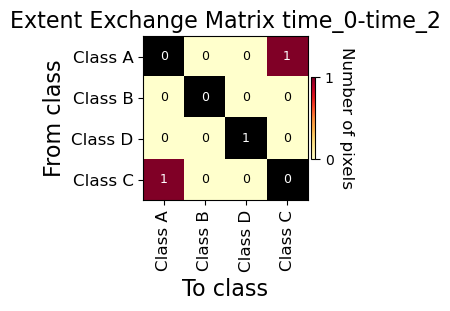

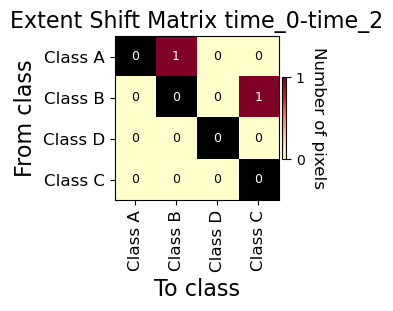

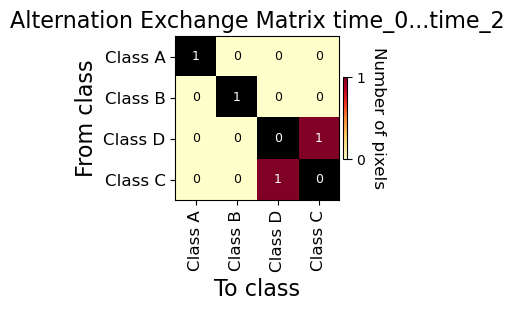

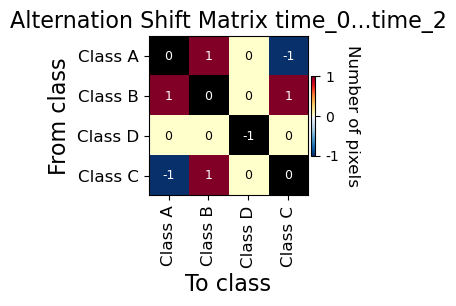

Saved 4 heatmaps for matrix decomposition:
1. /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/heatmap_EXTENT_EXCHANGE_time_0-time_2.png
2. /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/heatmap_EXTENT_SHIFT_time_0-time_2.png
3. /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/heatmap_ALTERNATION_EXCHANGE_time_0...time_2.png
4. /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/heatmap_ALTERNATION_SHIFT_time_0...time_2.png


In [13]:
# Paths for output figures
# We use '-' for Extent (depends only on Start-End)
# We use '...' for Alternation (depends on the full path Start...End)

FIG_EXT_EXC = OUT_DIR / f"heatmap_EXTENT_EXCHANGE_{Y0}-{Y1}.png"
FIG_EXT_SHIFT = OUT_DIR / f"heatmap_EXTENT_SHIFT_{Y0}-{Y1}.png"

FIG_ALT_EXC = OUT_DIR / f"heatmap_ALTERNATION_EXCHANGE_{Y0}...{Y1}.png"
FIG_ALT_SHIFT = OUT_DIR / f"heatmap_ALTERNATION_SHIFT_{Y0}...{Y1}.png"

# Plot the 4 Decomposed Components
# Notice the distinct naming convention in Titles and Filenames
for df, title, path in [
    (
        df_ext_exc_plot,
        f"Extent Exchange Matrix {Y0}-{Y1}",
        FIG_EXT_EXC,
    ),
    (
        df_ext_shift_plot,
        f"Extent Shift Matrix {Y0}-{Y1}",
        FIG_EXT_SHIFT,
    ),
    (
        df_alt_exc_plot,
        f"Alternation Exchange Matrix {Y0}...{Y1}",
        FIG_ALT_EXC,
    ),
    (
        df_alt_shift_plot,
        f"Alternation Shift Matrix {Y0}...{Y1}",
        FIG_ALT_SHIFT,
    ),
]:
    plot_heatmap(
        df=df,
        title=title,
        save_path=path,
        tick_fontsize=None,
        tick_fontsize_x=12,
        tick_fontsize_y=12,
        axis_label_fontsize=16,
        title_fontsize=16,
        ann_fontsize=9,
        cbar_fraction=0.025,
        cbar_pad=0.02,
    )

print(
    "Saved 4 heatmaps for matrix decomposition:",
)
print(
    f"1. {FIG_EXT_EXC}",
)
print(
    f"2. {FIG_EXT_SHIFT}",
)
print(
    f"3. {FIG_ALT_EXC}",
)
print(
    f"4. {FIG_ALT_SHIFT}",
)

## **6.Components of Change**


---
The code calculates components of change from transition matrices generated in the previous step. It features a ComponentCalculator class that processes matrices to determine the gain and loss of Quantity, Exchange, and Shift. The process_matrix function handles matrices for defined time intervals and the main function systematically processes these matrices for each time interval, aggregates the results, and exports the outcomes to a CSV file.

In [14]:
import os
import pandas as pd
import numpy as np

class ComponentCalculator:
    """
    Compute change components (Quantity, Exchange, Shift) for a matrix.
    Supports pre-decomposed matrices via force_component parameter.
    """
    def __init__(self, transition_matrix: np.ndarray) -> None:
        self.matrix = transition_matrix.astype(float)
        self.num_classes = transition_matrix.shape[0]
        self.class_components: list[dict] = []

    def calculate_components(self, force_component: str = None) -> "ComponentCalculator":
        for class_idx in range(self.num_classes):
            gain_sum = np.sum(self.matrix[:, class_idx])
            loss_sum = np.sum(self.matrix[class_idx, :])

            # Standard net change calculation
            q_gain = max(0.0, gain_sum - loss_sum)
            q_loss = max(0.0, loss_sum - gain_sum)

            if force_component == "Exchange":
                # Matrix content is treated purely as exchange (allows negatives for closure)
                exchange = loss_sum - self.matrix[class_idx, class_idx]
                shift = 0.0
                q_gain, q_loss = (gain_sum - loss_sum), (loss_sum - gain_sum)
            elif force_component == "Shift":
                # Matrix content is treated purely as shift
                exchange = 0.0
                shift = loss_sum - self.matrix[class_idx, class_idx]
                q_gain, q_loss = 0.0, 0.0
            else:
                # Standard Pontius decomposition
                mutual = np.sum(np.minimum(self.matrix[class_idx, :], self.matrix[:, class_idx]))
                exchange = mutual - self.matrix[class_idx, class_idx]
                total_trans = loss_sum - self.matrix[class_idx, class_idx]
                shift = total_trans - q_loss - exchange

            self.class_components.append({
                "Quantity_Gain": q_gain, "Quantity_Loss": q_loss,
                "Exchange_Gain": exchange, "Exchange_Loss": exchange,
                "Shift_Gain": shift, "Shift_Loss": shift,
            })
        return self

def process_matrix(matrix_type, output_path, years_list, start_year=None, end_year=None):
    results = []
    
    # 1. Determine naming patterns to search for (Short vs Long names)
    # This handles the mismatch between years=["time_0"...] and files="0-1.csv"
    patterns = []
    
    if matrix_type == "interval":
        # Try "time_0-time_1" AND "0-1"
        s_str, e_str = str(start_year), str(end_year)
        patterns.append(f"transition_matrix_{s_str}-{e_str}.csv")
        patterns.append(f"transition_matrix_{s_str.replace('time_', '')}-{e_str.replace('time_', '')}.csv")
        label_time = f"{s_str}-{e_str}"
    else:
        # Try "sum_time_0-time_2" AND "sum_0-2"
        y0_str, yN_str = str(years_list[0]), str(years_list[-1])
        patterns.append(f"transition_matrix_{matrix_type}_{y0_str}-{yN_str}.csv")
        patterns.append(f"transition_matrix_{matrix_type}_{y0_str.replace('time_', '')}-{yN_str.replace('time_', '')}.csv")
        label_time = matrix_type

    # 2. Find the existing file
    full_path = None
    for p in patterns:
        path = os.path.join(output_path, p)
        if os.path.exists(path):
            full_path = path
            break
    
    if not full_path:
        return []

    # 3. Process components
    force_comp = "Exchange" if "exchange" in matrix_type else ("Shift" if "shift" in matrix_type else None)
    
    df_mat = pd.read_csv(full_path, index_col=0)
    calc = ComponentCalculator(df_mat.values).calculate_components(force_component=force_comp)

    for idx, class_id in enumerate([int(c) for c in df_mat.index]):
        # Use simple "Class X" if class_labels_dict is missing or generic
        cls_name = class_labels_dict.get(class_id, {}).get("name", f"Class {class_id}")
        comp_vals = calc.class_components[idx]
        
        for comp_name in ["Quantity", "Exchange", "Shift"]:
            # Standardize component labels for the plot
            label_comp = comp_name
            if matrix_type in ["extent", "sum"]: label_comp = f"Allocation_{comp_name}"
            if "alternation" in matrix_type: label_comp = f"Alternation_{comp_name}"

            results.append({
                "Time_Interval": label_time,
                "Class": cls_name,
                "Component": label_comp,
                "Gain": comp_vals[f"{comp_name}_Gain"],
                "Loss": comp_vals[f"{comp_name}_Loss"],
            })
    return results

def main(output_path):
    all_results = []
    # 1) Annual Intervals
    for i in range(len(years) - 1):
        all_results.extend(process_matrix("interval", output_path, years, years[i], years[i+1]))
    
    # 2) Aggregated Matrices
    for mtype in ["extent", "sum", "alternation_exchange", "alternation_shift"]:
        all_results.extend(process_matrix(mtype, output_path, years))

    df_out = pd.DataFrame(all_results)
    output_file = os.path.join(output_path, "change_components.csv")
    df_out.to_csv(output_file, index=False)
    print(f"Success! Final components saved to {output_file}")

if __name__ == "__main__":
    main(output_path=output_path)

Success! Final components saved to /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/change_components.csv


## **6.Graphics**

---



### **6.1 Setting the parameters for the graphics**

In [15]:
# Read change components CSV
csv_path = os.path.join(
    output_path,
    "change_components.csv",
)

# Validate path
if not os.path.exists(csv_path):
    raise FileNotFoundError(
        f"CSV not found: {csv_path}",
    )

print(f"Loaded change components from: {csv_path}")

# Load into DataFrame
df = pd.read_csv(
    csv_path,
)


Loaded change components from: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/change_components.csv


### **6.2 Change Components by Time Interval**

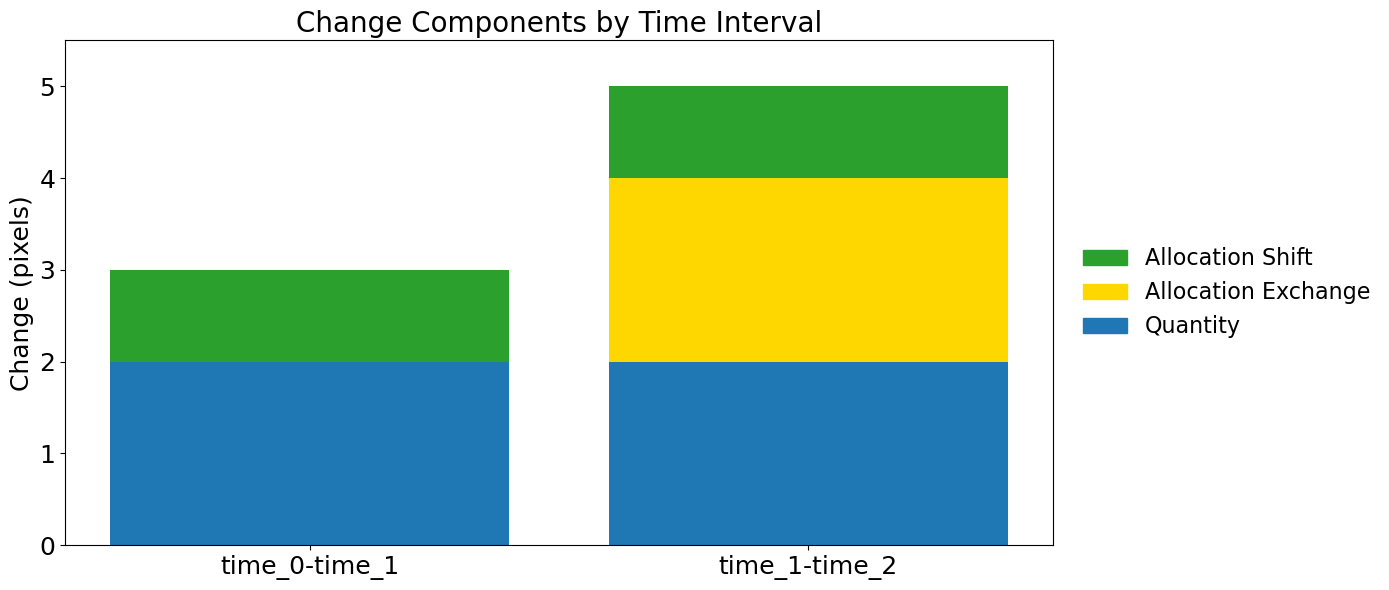

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_change_components_by_interval(
    df: pd.DataFrame,
    output_path: str,
) -> None:
    """
    Plot change components (Quantity, Exchange, Shift) for each time interval.

    This function filters the dataframe for interval-based rows (containing '-'),
    standardizes component names, and generates a stacked bar chart.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing change components data.
    output_path : str
        Directory to save the output figure.
    """
    
    # Filter only rows representing time intervals (containing hyphens)
    df_intervals = df[
        df["Time_Interval"].str.contains("-")
    ].copy()

    # Standardize component names by removing prefixes to group common types
    df_intervals["Component"] = df_intervals["Component"].str.replace(
        "Allocation_", 
        "",
    ).str.replace(
        "Alternation_", 
        "",
    )

    # Aggregate totals by pivoting the table
    # Fill missing values with 0 to ensure valid mathematical operations
    totals = (
        df_intervals.groupby(
            [
                "Time_Interval", 
                "Component",
            ],
        )["Gain"]
        .sum()
        .unstack()
        .fillna(
            0,
        )
    )

    # dynamically identify which components are present in the data
    available_components = [
        component
        for component in [
            "Quantity", 
            "Exchange", 
            "Shift",
        ] 
        if component in totals.columns
    ]

    # Calculate the maximum value to determine the appropriate scale factor
    if not totals.empty and available_components:
        max_val = totals[
            available_components
        ].to_numpy().max()
    else:
        max_val = 0

    # Determine scale factor and y-axis label based on data magnitude
    if max_val >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Change (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000
        y_label = "Change (thousand pixels)"
    else:
        scale_factor = 1
        y_label = "Change (pixels)"

    # Apply scaling to the data
    scaled_totals = totals[
        available_components
    ] / scale_factor

    # Calculate the maximum stacked height for y-axis limits
    stacked_max = scaled_totals.sum(
        axis=1,
    ).max()

    # Initialize the figure and axis
    fig, ax = plt.subplots(
        figsize=(
            14, 
            6,
        ),
    )

    # Define standard colors for the components
    colors_map = {
        "Quantity": "#1f77b4",
        "Exchange": "#ffd700",
        "Shift": "#2ca02c",
    }
    
    # Standard list of colors matching the available components order
    colors = [
        colors_map.get(
            comp, 
            "#333333",
        ) 
        for comp in available_components
    ]

    # Plot stacked bars for each available component
    for idx, component in enumerate(available_components):
        # Calculate the bottom position for stacking
        if idx > 0:
            bottom_values = scaled_totals.iloc[
                :, 
                :idx
            ].sum(
                axis=1,
            )
        else:
            bottom_values = 0
            
        ax.bar(
            totals.index,
            scaled_totals[component],
            label=component,
            color=colors[idx % len(colors)],
            edgecolor="none",
            bottom=bottom_values,
        )

    # Format the axes
    ax.set_ylabel(
        y_label, 
        fontsize=18,
    )
    ax.set_title(
        "Change Components by Time Interval", 
        fontsize=20,
    )
    ax.tick_params(
        axis="both", 
        labelsize=18,
    )

    # Ensure y-axis ticks are integers (useful for small datasets)
    ax.yaxis.set_major_locator(
        ticker.MaxNLocator(
            integer=True,
        ),
    )
    ax.yaxis.set_major_formatter(
        ticker.FormatStrFormatter(
            "%d",
        ),
    )

    # Set y-axis limits with a margin
    ax.set_ylim(
        0, 
        max(
            1, 
            stacked_max * 1.1,
        ),
    )

    # Create a custom legend with fixed colors and labels
    legend_elements = [
        plt.Rectangle(
            (0, 0), 
            1, 
            1, 
            color="#2ca02c", 
            label="Allocation Shift",
        ),
        plt.Rectangle(
            (0, 0), 
            1, 
            1, 
            color="#ffd700", 
            label="Allocation Exchange",
        ),
        plt.Rectangle(
            (0, 0), 
            1, 
            1, 
            color="#1f77b4", 
            label="Quantity",
        ),
    ]
    
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.01, 
            0.5,
        ),
        fontsize=16,
        frameon=False,
    )

    # Final layout adjustment and save
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_interval.jpeg",
        ),
        bbox_inches="tight",
        format="jpeg",
        dpi=300,
    )
    plt.show()

# Example usage (assuming 'df' and 'output_path' are defined in the notebook)
if __name__ == "__main__":
    plot_change_components_by_interval(
        df,
        output_path,
    )

### **6.3 Change Components Overall**

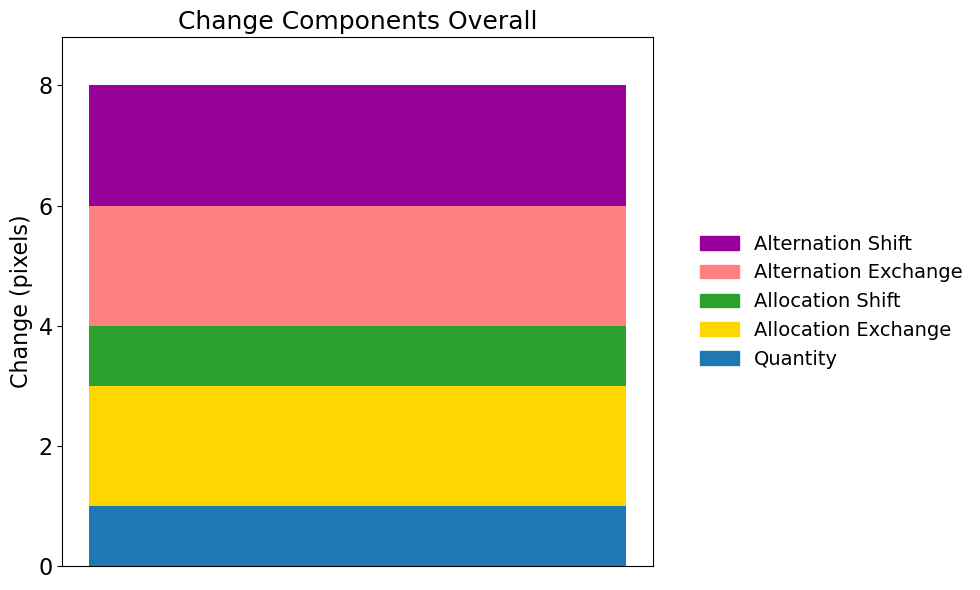

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_components_with_alternation(
    csv_path: str,
    output_path: str,
) -> None:
    """
    Plot overall change components as a single stacked bar with auto-scaled y-axis.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file containing change components.
    output_path : str
        Directory where the output figure will be saved.
    """

    # Load data
    df = pd.read_csv(
        csv_path,
    )

    # Colors and component order
    components_color = {
        "Quantity": "#1f77b4",
        "Allocation_Exchange": "#ffd700",
        "Alternation_Exchange": "#ff8080",
        "Allocation_Shift": "#2ca02c",
        "Alternation_Shift": "#990099",
    }
    
    component_order = [
        "Quantity",
        "Allocation_Exchange",
        "Allocation_Shift",
        "Alternation_Exchange",
        "Alternation_Shift",
    ]

    # Aggregate totals per component
    # Allocation components are retrieved from the 'extent' interval rows.
    # Alternation components use positive/negative filtering to represent 
    # the correct magnitude of change in complex trajectories.
    component_totals = {
        "Quantity": df[
            (df["Component"] == "Allocation_Quantity")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Exchange": df[
            (df["Component"] == "Allocation_Exchange")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Shift": df[
            (df["Component"] == "Allocation_Shift")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Alternation_Exchange": df[
            (df["Time_Interval"] == "alternation_exchange") &
            (df["Gain"] > 0)
        ]["Gain"].sum(),
        "Alternation_Shift": df[
            (df["Time_Interval"] == "alternation_shift")
        ]["Gain"].sum() + df[
            (df["Time_Interval"] == "alternation_exchange") &
            (df["Gain"] < 0)
        ]["Gain"].sum(),
    }

    # Automatic scale based on the sum of all stacked components
    total_change = sum(
        component_totals.values(),
    )

    if total_change >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Change (million pixels)"
    elif total_change >= 1_000:
        scale_factor = 1_000
        y_label = "Change (thousand pixels)"
    elif total_change >= 100:
        scale_factor = 100
        y_label = "Change (hundred pixels)"
    else:
        scale_factor = 1
        y_label = "Change (pixels)"

    # Initialize figure and axis
    fig, ax = plt.subplots(
        figsize=(
            10,
            6,
        ),
    )

    # Plot each component in a stacked bar at a single x-position
    bottom = 0.0
    for component in component_order:
        value = component_totals.get(
            component,
            0.0,
        ) / scale_factor
        ax.bar(
            x=0,
            height=value,
            bottom=bottom,
            color=components_color[component],
            edgecolor="none",
            width=0.8,
        )
        bottom += value

    # Axes formatting and labels
    ax.set_ylabel(
        y_label,
        fontsize=16,
    )
    ax.set_title(
        "Change Components Overall",
        fontsize=18,
    )
    ax.xaxis.set_visible(
        False,
    )
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=16,
    )

    # Set y-axis limits and major tick locators
    y_max_scaled = bottom * 1.1 if bottom > 0 else 1.0
    ax.set_ylim(
        0,
        y_max_scaled,
    )
    ax.yaxis.set_major_locator(
        ticker.MaxNLocator(
            nbins=5,
            integer=True,
        ),
    )

    ax.yaxis.set_major_formatter(
        ticker.FormatStrFormatter(
            "%d",
        ),
    )

    # Configure visible spines for the plot frame
    for spine in [
        "top",
        "right",
        "left",
        "bottom",
    ]:
        ax.spines[spine].set_visible(
            True,
        )

    # Define custom legend elements using the specified colors and labels
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Shift"],
            label="Alternation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Exchange"],
            label="Alternation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Shift"],
            label="Allocation Shift",
            ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Exchange"],
            label="Allocation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Quantity"],
            label="Quantity",
        ),
    ]
    
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.05,
            0.5,
        ),
        fontsize=14,
        frameon=False,
    )

    # Final layout adjustment and export
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_overall.jpeg",
        ),
        bbox_inches="tight",
        format="jpeg",
        dpi=300,
    )
    plt.show()

if __name__ == "__main__":
    # Specify paths and execute the plotting function
    csv_file = os.path.join(
        output_path,
        "change_components.csv",
    )
    plot_components_with_alternation(
        csv_file,
        output_path,
    )

### **6.4 Change Componentes by Class**

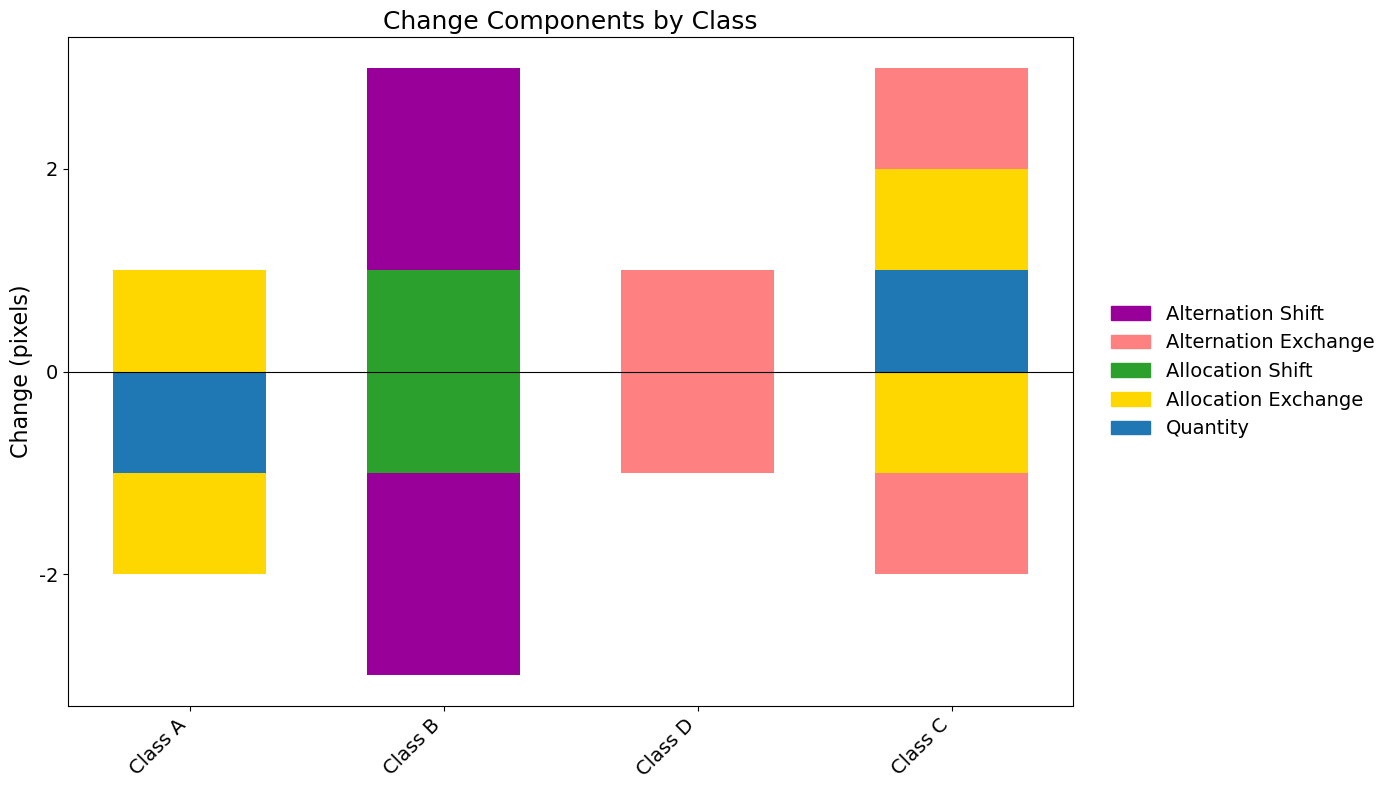

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

class ComponentVisualizer:
    """
    Visualize change components by class, handling negative correction terms
    in alternation components correctly.
    """

    @staticmethod
    def plot_gain_loss_stacked(
        df: pd.DataFrame,
        class_labels_dict: dict,
        title: str,
        output_path: str,
    ) -> None:
        """
        Plot per-class gains and losses as stacked bars with auto-scaled y-axis.
        """
        
        # 1. Filter and Prepare Data
        target_intervals = [
            "extent", 
            "alternation_exchange", 
            "alternation_shift",
        ]
        
        # Select rows
        df_sub = df[
            df["Time_Interval"].isin(
                target_intervals,
            )
        ].copy()

        # Rename 'Allocation_Quantity' to 'Quantity' for consistency
        df_sub["Component"] = df_sub["Component"].str.replace(
            "Allocation_Quantity", 
            "Quantity",
        )

        # 2. Colors and Order
        components_map = {
            "Quantity": "#1f77b4",
            "Allocation_Exchange": "#ffd700",
            "Alternation_Exchange": "#ff8080",
            "Allocation_Shift": "#2ca02c",
            "Alternation_Shift": "#990099",
        }
        
        # We process these groups separately to handle the math
        comp_groups = [
            "Quantity",
            "Allocation_Exchange",
            "Allocation_Shift",
        ]

        # 3. Identify Classes and Sort by Net Quantity Change
        classes = sorted(
            df_sub["Class"].unique(),
        )
        
        # Calculate Net Quantity for Sorting
        class_stats = []
        for cls in classes:
            c_data = df_sub[df_sub["Class"] == cls]
            qty_gain = c_data[c_data["Component"] == "Quantity"]["Gain"].sum()
            qty_loss = c_data[c_data["Component"] == "Quantity"]["Loss"].sum()
            class_stats.append((cls, qty_gain - qty_loss))

        # Sort classes
        ordered_classes = [
            x[0] for x in sorted(
                class_stats, 
                key=lambda x: x[1],
            )
        ]

        # 4. Prepare Plot Data (Handling the Net Logic)
        plot_data = [] # List of dicts per class
        max_height = 0.0

        for cls in ordered_classes:
            c_data = df_sub[df_sub["Class"] == cls]
            
            # --- GAINS ---
            # Standard Components
            gains = {}
            for comp in comp_groups:
                gains[comp] = c_data[c_data["Component"] == comp]["Gain"].sum() # Allocation is usually positive

            # Alternation Logic (Consolidate Exchange + Shift)
            raw_alt_exc = c_data[c_data["Component"] == "Alternation_Exchange"]["Gain"].sum()
            raw_alt_shift = c_data[c_data["Component"] == "Alternation_Shift"]["Gain"].sum()
            net_alt = raw_alt_exc + raw_alt_shift
            
            # If Net Alternation is effectively 0, plot neither.
            # If positive, attribute to Exchange first if valid, else Shift.
            adj_alt_exc = 0.0
            adj_alt_shift = 0.0
            
            if net_alt > 0.0001:
                # If raw exchange is positive (like Class D), keep it
                if raw_alt_exc > 0:
                    adj_alt_exc = raw_alt_exc
                    adj_alt_shift = max(0, net_alt - raw_alt_exc)
                else:
                    # If raw exchange is negative (Class A correction), hide it inside Shift
                    adj_alt_exc = 0
                    adj_alt_shift = net_alt
            
            gains["Alternation_Exchange"] = adj_alt_exc
            gains["Alternation_Shift"] = adj_alt_shift

            # --- LOSSES (Logic is identical but using Loss column) ---
            losses = {}
            for comp in comp_groups:
                losses[comp] = c_data[c_data["Component"] == comp]["Loss"].sum()

            raw_alt_exc_l = c_data[c_data["Component"] == "Alternation_Exchange"]["Loss"].sum()
            raw_alt_shift_l = c_data[c_data["Component"] == "Alternation_Shift"]["Loss"].sum()
            net_alt_l = raw_alt_exc_l + raw_alt_shift_l
            
            adj_alt_exc_l = 0.0
            adj_alt_shift_l = 0.0
            
            if net_alt_l > 0.0001:
                if raw_alt_exc_l > 0:
                    adj_alt_exc_l = raw_alt_exc_l
                    adj_alt_shift_l = max(0, net_alt_l - raw_alt_exc_l)
                else:
                    adj_alt_exc_l = 0
                    adj_alt_shift_l = net_alt_l

            losses["Alternation_Exchange"] = adj_alt_exc_l
            losses["Alternation_Shift"] = adj_alt_shift_l

            # Track max height for scaling
            total_g = sum(gains.values())
            total_l = sum(losses.values())
            max_height = max(max_height, total_g, total_l)
            
            plot_data.append({
                "class": cls,
                "gains": gains,
                "losses": losses
            })

        # 5. Determine Scale Factor
        if max_height >= 1_000_000:
            scale_factor = 1_000_000
            y_label = "Change (million pixels)"
        elif max_height >= 1_000:
            scale_factor = 1_000
            y_label = "Change (thousand pixels)"
        else:
            scale_factor = 1
            y_label = "Change (pixels)"

        # 6. Plotting
        fig, ax = plt.subplots(figsize=(14, 8))
        fig.subplots_adjust(left=0.1, right=0.75)
        
        x_pos = np.arange(len(ordered_classes))
        width = 0.6
        
        # Order for stacking: Quantity at bottom, then Alloc, then Alt
        stack_order = [
            "Quantity", 
            "Allocation_Exchange", 
            "Allocation_Shift", 
            "Alternation_Exchange", 
            "Alternation_Shift"
        ]

        for idx, item in enumerate(plot_data):
            # Gains (Upwards)
            bottom_g = 0.0
            for comp in stack_order:
                val = item["gains"][comp] / scale_factor
                if val > 0:
                    ax.bar(
                        x_pos[idx], 
                        val, 
                        width, 
                        bottom=bottom_g, 
                        color=components_map[comp], 
                        edgecolor="none"
                    )
                    bottom_g += val
            
            # Losses (Downwards)
            bottom_l = 0.0
            for comp in stack_order:
                val = item["losses"][comp] / scale_factor
                if val > 0:
                    ax.bar(
                        x_pos[idx], 
                        -val, 
                        width, 
                        bottom=bottom_l, 
                        color=components_map[comp], 
                        edgecolor="none"
                    )
                    bottom_l -= val

        # 7. Formatting
        class_names = [
            class_labels_dict.get(
                int(c) if str(c).isdigit() else c, {}
            ).get("name", str(c))
            for c in ordered_classes
        ]
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(class_names, rotation=45, ha="right", fontsize=14)
        ax.axhline(0, color="black", linewidth=0.8)
        
        ax.set_ylabel(y_label, fontsize=16)
        ax.set_title(title, fontsize=18)
        ax.tick_params(axis="both", labelsize=14)

        # Y-Axis Limits and Integer Ticks
        limit = max_height / scale_factor * 1.1 if max_height > 0 else 1.0
        ax.set_ylim(-limit, limit)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=6))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

        # Legend
        handles = [
            plt.Rectangle((0,0),1,1, color=components_map[c], label=c.replace("_", " "))
            for c in reversed(stack_order) # Top to bottom order in legend
        ]
        
        ax.legend(
            handles=handles,
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            fontsize=14,
            frameon=False
        )

        plt.tight_layout()
        plt.savefig(
            os.path.join(output_path, "graphic_change_component_change_class.jpeg"),
            dpi=300, bbox_inches="tight"
        )
        plt.show()

if __name__ == "__main__":
    ComponentVisualizer.plot_gain_loss_stacked(
        df=df,
        class_labels_dict=class_labels_dict,
        title="Change Components by Class",
        output_path=output_path,
    )

## **7. Number of Changes**

### 7.1 Compute Number of Changes

In [64]:
from tqdm import tqdm

# Parameters
CHUNK_SIZE = 512          # rows per chunk
BLOCK_SIZE = 256          # tiled block size

# Usa o nodata_value definido anteriormente (por exemplo, 255)
NODATA = noData_value

# Output path
output_raster_path = os.path.join(
    output_path,
    "number_of_changes.tif",
)

print("Starting memory-efficient calculation of number of changes...")

# Template metadata from first masked raster
with rasterio.open(masked_image_paths[0]) as src:
    meta = src.meta.copy()
    height, width = src.shape

# Update output metadata for tiled GeoTIFF
meta.update(
    {
        "dtype": "uint8",
        "count": 1,
        "compress": "lzw",
        "tiled": True,
        "blockxsize": BLOCK_SIZE,
        "blockysize": BLOCK_SIZE,
    },
)

# Create output raster and process in chunks
with rasterio.open(
    output_raster_path,
    "w",
    **meta,
) as dst:
    print(f"Output raster will be written to: {output_raster_path}")

    # Number of vertical chunks
    n_chunks = (height + CHUNK_SIZE - 1) // CHUNK_SIZE

    # Iterate over chunks with progress bar
    for y_start in tqdm(
        range(0, height, CHUNK_SIZE),
        total=n_chunks,
        desc="Change count processing",
        unit="step",
    ):
        y_end = min(
            y_start + CHUNK_SIZE,
            height,
        )
        chunk_h = y_end - y_start
        window = rasterio.windows.Window(
            0,
            y_start,
            width,
            chunk_h,
        )

        # Read current block from each year into a stack
        chunk_stack = np.zeros(
            (
                len(masked_image_paths),
                chunk_h,
                width,
            ),
            dtype=np.uint8,
        )
        for i, path in enumerate(masked_image_paths):
            with rasterio.open(path) as src:
                chunk_stack[i] = src.read(
                    1,
                    window=window,
                )

        # Vectorized change count between consecutive rasters
        # Ignore transitions when previous state is background (0)
        transitions = (
            (chunk_stack[1:] != chunk_stack[:-1])
            & (chunk_stack[:-1] != 0)
        )
        number_of_changes_chunk = np.sum(
            transitions,
            axis=0,
            dtype=np.uint8,
        )

        # Combined background mask (background in all dates)
        background_mask = np.all(
            chunk_stack == 0,
            axis=0,
        )
        number_of_changes_chunk[background_mask] = NODATA

        # Write block to output raster
        dst.write(
            number_of_changes_chunk,
            1,
            window=window,
        )

print(f"Calculation complete. Raster saved to: {output_raster_path}")

Starting memory-efficient calculation of number of changes...
Output raster will be written to: /Users/antoniofonseca/Dataset/toydata/toydata1/number_of_changes.tif


Change count processing: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.50step/s]

Calculation complete. Raster saved to: /Users/antoniofonseca/Dataset/toydata/toydata1/number_of_changes.tif


### 7.2 Plot Number of Changes Map

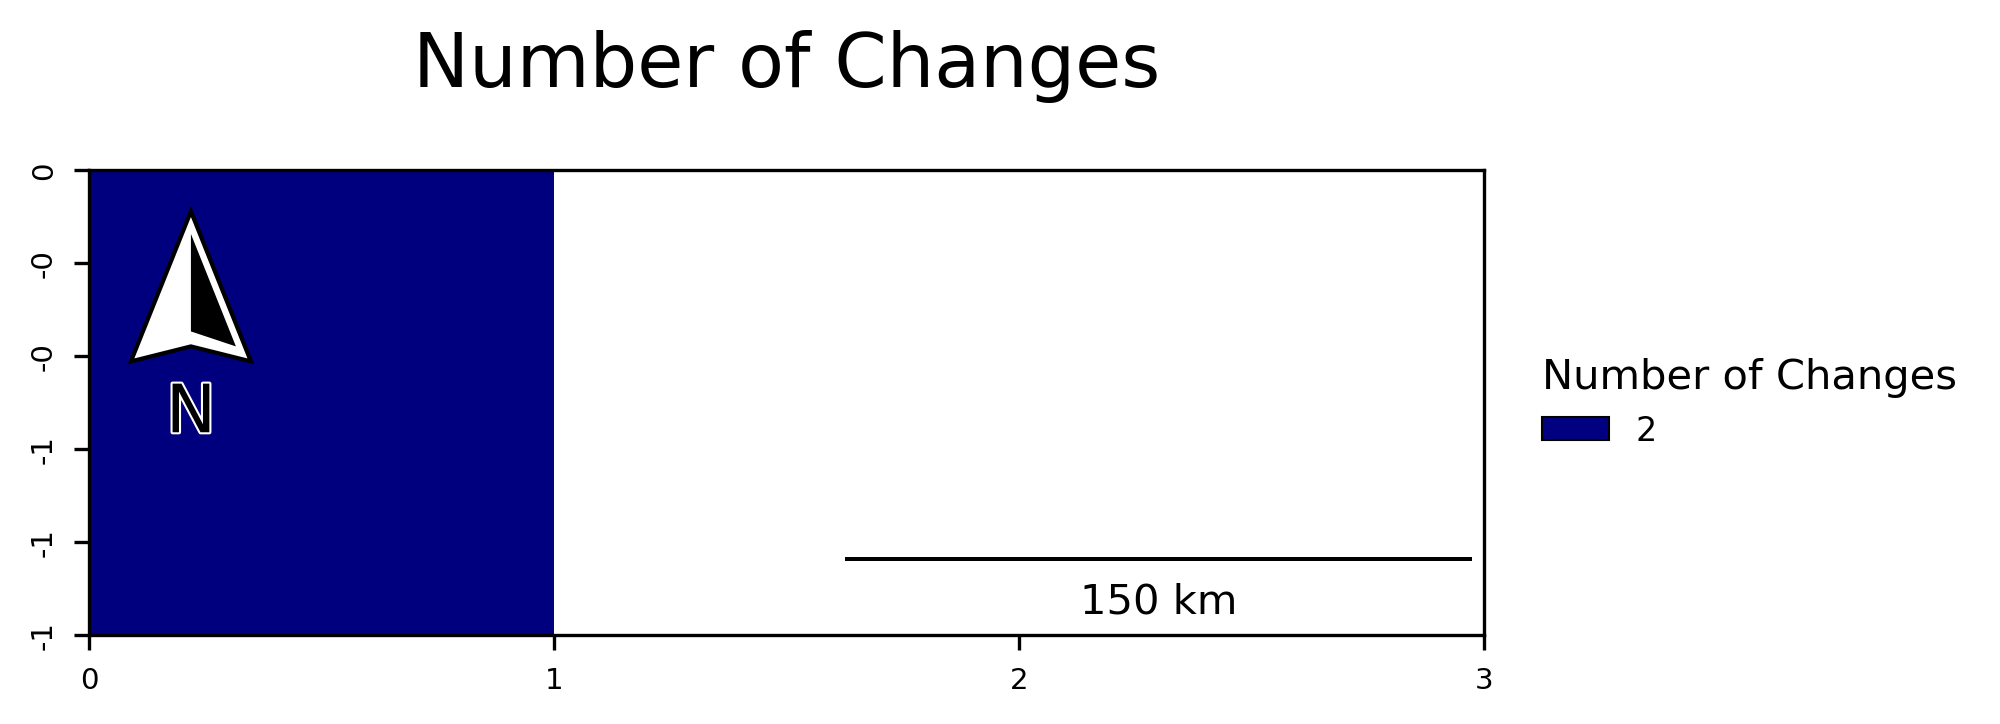

Map figure saved successfully to: /Users/antoniofonseca/Dataset/toydata/toydata1/map_number_of_changes.png


In [65]:
# 1) Input raster path
raster_to_plot_path = os.path.join(
    output_path,
    "number_of_changes.tif",
)

# 2) Read raster and basic metadata
with rasterio.open(raster_to_plot_path) as src:
    scale_factor = 1

    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor),
        ),
        resampling=rasterio.enums.Resampling.nearest,
    )

    nodata_value = src.nodata
    if nodata_value is not None:
        data = np.ma.masked_equal(
            data,
            nodata_value,
        )

    left, bottom, right, top = src.bounds
    src_crs = src.crs
    transform = src.transform

# 3) Figure
fig, ax = plt.subplots(
    figsize=(
        6,
        8,
    ),
    dpi=300,
)

# Data range
min_val = int(
    np.ma.min(data),
)
max_val = int(
    np.ma.max(data),
)

# 4) Colormap (gray for 0 + jet for 1..max)
original_cmap = plt.get_cmap(
    "jet",
)
color_list = [
    "#c0c0c0",
] + [
    original_cmap(i)
    for i in np.linspace(
        0,
        1,
        max_val,
    )
]
cmap = ListedColormap(
    color_list,
)

# Discrete normalization
bounds = np.arange(
    min_val,
    max_val + 2,
) - 0.5
norm = BoundaryNorm(
    bounds,
    cmap.N,
)

# 5) Plot raster in original projection coordinates
ax.imshow(
    data,
    extent=[
        left,
        right,
        bottom,
        top,
    ],
    cmap=cmap,
    interpolation="none",
    norm=norm,
)

# 6) Discrete box legend
legend_elements = []
for i in range(
    min_val,
    max_val + 1,
):
    legend_elements.append(
        Patch(
            facecolor=cmap(
                norm(i),
            ),
            edgecolor="black",
            linewidth=0.5,
            label=str(i),
        ),
    )

ax.legend(
    handles=legend_elements,
    title="Number of Changes",
    loc="center left",
    bbox_to_anchor=(
        1.02,
        0.5,
    ),
    frameon=False,
    fontsize=8,
    title_fontsize=10,
    alignment="left",
)

# 7) Cartographic elements (scale bar + north arrow)

# Compute approximate pixel size in meters for any CRS
if src_crs is not None and src_crs.is_projected:
    pixel_size_m = transform.a
else:
    from pyproj import Geod, CRS

    geod = Geod(
        ellps="WGS84",
    )
    crs_ll = CRS.from_epsg(
        4326,
    )

    if src_crs is not None and src_crs.to_string() != crs_ll.to_string():
        transformer_ll = Transformer.from_crs(
            src_crs,
            crs_ll,
            always_xy=True,
        )
    else:
        transformer_ll = None

    x_center = (left + right) / 2.0
    y_center = (bottom + top) / 2.0

    if transformer_ll is not None:
        lon_center, lat_center = transformer_ll.transform(
            x_center,
            y_center,
        )
        lon_right, _ = transformer_ll.transform(
            x_center + transform.a,
            y_center,
        )
    else:
        lon_center, lat_center = x_center, y_center
        lon_right = x_center + transform.a

    _, _, dist_m = geod.inv(
        lon_center,
        lat_center,
        lon_right,
        lat_center,
    )
    pixel_size_m = dist_m

scalebar = ScaleBar(
    dx=pixel_size_m / 1000.0,
    units="km",
    length_fraction=0.5,
    location="lower right",
    box_alpha=0.0,
    scale_formatter=lambda value, _: f"{int(value)} km",
)
ax.add_artist(
    scalebar,
)

north_arrow(
    ax,
    location="upper left",
    shadow=False,
    rotation={
        "degrees": 0,
    },
)

# 8) Axes styling
ax.set_title(
    "Number of Changes",
    fontsize=18,
    pad=20,
)
ax.set_aspect(
    "equal",
)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=7,
    pad=4,
)
ax.xaxis.set_major_locator(
    plt.MaxNLocator(
        3,
    ),
)
ax.yaxis.set_major_locator(
    plt.MaxNLocator(
        6,
    ),
)

# Show y-axis coordinates on the left, vertically
from matplotlib.ticker import FuncFormatter

ax.yaxis.set_major_formatter(
    FuncFormatter(
        lambda y, pos: f"{y:.0f}",
    ),
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va="center",
)

# 9) Save
output_figure_path = os.path.join(
    output_path,
    "map_number_of_changes.png",
)
plt.savefig(
    output_figure_path,
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.5,
)
plt.show()

print(
    f"Map figure saved successfully to: {output_figure_path}",
)

## **8. Trajectory Classification**


---
This section provides a framework for processing and classifying pixel trajectories in raster datasets.


### 8.1 Compute Trajectory Analysis
This section processes and visualizes raster data by scaling, applying a color map, and adding graphical elements like legends, scale bars, and north arrows. The output is a high-resolution image of the classified raster data.

In [20]:
import os
import glob
import numpy as np
import rasterio
import numba as nb
from numba import prange
from tqdm import tqdm


@nb.njit(
    nogil=True,
)
def classify_pixel(
    pixel_series: np.ndarray,
) -> np.uint8:
    """
    Classify a single pixel trajectory into four categories based on temporal changes.

    Parameters
    ----------
    pixel_series : np.ndarray
        A 1D numpy array representing the land cover class values
        of a single pixel over time.

    Returns
    -------
    np.uint8
        An integer representing the trajectory class:
        0: NoData (Background)
        1: Stable (No change)
        2: Alternation (Change occurs, but Start Class == End Class)
        3: Step (Start != End, and a direct transition exists)
        4: Complex (Start != End, and no direct transition exists)
    """
    if pixel_series[
        0
    ] == 0:
        return np.uint8(
            0,
        )

    start = pixel_series[
        0
    ]
    end = pixel_series[
        -1
    ]

    has_variation = False
    direct_transition = False

    for i in range(
        len(
            pixel_series,
        ) - 1,
    ):
        current = pixel_series[
            i
        ]
        next_val = pixel_series[
            i + 1
        ]

        if current != next_val:
            has_variation = True
            if (
                current == start
            ) and (
                next_val == end
            ):
                direct_transition = True

    if not has_variation:
        return np.uint8(
            1,
        )

    if start == end:
        return np.uint8(
            2,
        )

    if direct_transition:
        return np.uint8(
            3,
        )

    return np.uint8(
        4,
    )


@nb.njit(
    nogil=True,
    parallel=True,
)
def process_stack_parallel(
    stack: np.ndarray,
    height: int,
    width: int,
) -> np.ndarray:
    """
    Apply pixel classification to a 3D raster stack using parallel processing.

    Parameters
    ----------
    stack : np.ndarray
        A 3D numpy array of shape (time, height, width) containing
        the stacked raster data.
    height : int
        The height (number of rows) of the spatial grid.
    width : int
        The width (number of columns) of the spatial grid.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (height, width) containing the
        classified trajectory codes (uint8).
    """
    result = np.zeros(
        (
            height,
            width,
        ),
        dtype=np.uint8,
    )
    for y in prange(
        height,
    ):
        for x in range(
            width,
        ):
            result[
                y, 
                x,
            ] = classify_pixel(
                stack[
                    :, 
                    y, 
                    x,
                ],
            )
    return result


class TrajectoryAnalyzer:
    """
    Manage the loading, processing, and saving of land cover trajectory analysis.
    """

    @staticmethod
    def process_rasters(
        output_path: str,
        suffix: str = ".tif",
        chunk_size: int = 1000,
    ) -> str:
        """
        Load time-series rasters, classify trajectories, and save the result.

        Parameters
        ----------
        output_path : str
            The directory path containing input rasters and where
            the output file will be saved.
        suffix : str, optional
            The filename suffix to identify input rasters (e.g., "_masked.tif"),
            by default ".tif".
        chunk_size : int, optional
            The size of chunks for processing (reserved for future implementation),
            by default 1000.

        Returns
        -------
        str
            The full file path to the generated trajectory raster.

        Raises
        ------
        FileNotFoundError
            If no rasters matching the specified suffix or fallback patterns
            are found in the input directory.
        """
        input_dir = os.path.join(
            output_path,
            "input_rasters",
        )
        
        search_pattern = os.path.join(
            input_dir,
            f"*{suffix}",
        )
        image_paths = sorted(
            glob.glob(
                search_pattern,
            ),
        )
        
        if not image_paths:
            fallback_pattern = os.path.join(
                input_dir,
                "time_*.tif",
            )
            image_paths = sorted(
                glob.glob(
                    fallback_pattern,
                ),
            )
        
        if not image_paths:
            raise FileNotFoundError(
                f"No rasters found in {input_dir}",
            )

        print(
            f"Found {len(image_paths)} rasters. Starting processing...",
        )

        with rasterio.open(
            image_paths[0],
        ) as src:
            meta = src.meta.copy()
            height = src.height
            width = src.width

        stack_list = []
        for p in tqdm(
            image_paths,
            desc="Loading rasters",
        ):
            with rasterio.open(
                p,
            ) as src:
                stack_list.append(
                    src.read(
                        1,
                    ),
                )
        
        stack = np.array(
            stack_list,
        )

        print(
            "Classifying trajectories...",
        )
        
        trajectory_map = process_stack_parallel(
            stack,
            height,
            width,
        )

        meta.update(
            dtype=np.uint8,
            count=1,
            nodata=0,
        )
        
        out_file = os.path.join(
            output_path,
            "trajectory.tif",
        )
        
        with rasterio.open(
            out_file,
            "w",
            **meta,
        ) as dst:
            dst.write(
                trajectory_map,
                1,
            )
            
        print(
            f"Trajectory map saved successfully to: {out_file}",
        )
            
        return out_file


print(
    "Starting trajectory analysis...",
)

trajectory_file = TrajectoryAnalyzer.process_rasters(
    output_path=output_path,
    suffix="_masked.tif",
    chunk_size=500,
)

Starting trajectory analysis...
Found 3 rasters. Starting processing...


Loading rasters: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00, 1390.84it/s]

Classifying trajectories...



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Trajectory map saved successfully to: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_toydata2/trajectory.tif


/Users/antoniofonseca/miniconda3/envs/geo/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


### 8.2 Plot Trajectory Analysis Graphic

Unique values in raster: [2 3 4]
Computed Percentages: {2: np.float64(20.0), 3: np.float64(40.0), 4: np.float64(40.0)}


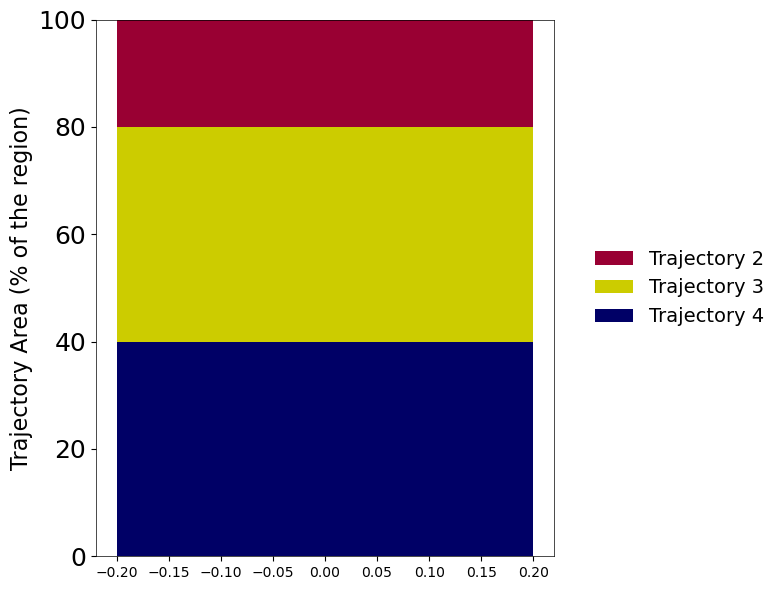

In [21]:
# Trajectory distribution plotting with Diagnostics and PEP8 compliance

def plot_trajectory_distribution(
    output_path: str,
) -> None:
    """Plot a stacked bar with the distribution of trajectory classes."""
    raster_path = os.path.join(
        output_path,
        "trajectory.tif",
    )

    with rasterio.open(
        raster_path,
    ) as src:
        traj_data = src.read(
            1,
        )
        nodata = src.nodata

    masked_traj = np.ma.masked_where(
        traj_data == nodata,
        traj_data,
    )
    
    unique_vals, counts = np.unique(
        masked_traj.compressed(),
        return_counts=True,
    )
    
    data_counts = dict(
        zip(
            unique_vals,
            counts,
        ),
    )
    
    total_pixels = sum(
        data_counts.values(),
    )

    # REVISÃO: Verifique no console se a Trajectory 2 aparece aqui
    print(
        f"Unique values in raster: {unique_vals}",
    )
    
    percentages = {
        i: (
            data_counts.get(
                i, 
                0,
            ) / total_pixels
        ) * 100.0
        for i in [
            2,
            3,
            4,
        ]
    }

    print(
        f"Computed Percentages: {percentages}",
    )

    ordered_trajs = [
        4,
        3,
        2,
    ]
    colors = {
        4: "#000066",  # Dark Blue
        3: "#cccc00",  # Yellow
        2: "#990033",  # Dark Red
    }

    # Rest of the plot code...
    fig, ax = plt.subplots(
        figsize=(
            8,
            6,
        ),
    )

    bottom = 0.0
    for traj in ordered_trajs:
        val = percentages[
            traj
        ]
        ax.bar(
            0,
            val,
            bottom=bottom,
            color=colors[
                traj
            ],
            width=0.4,
            edgecolor="none",
        )
        bottom += val

    ax.set_ylabel(
        "Trajectory Area (% of the region)",
        fontsize=16,
    )

    for spine in [
        "top",
        "right",
        "bottom",
        "left",
    ]:
        ax.spines[
            spine
        ].set_visible(
            True,
        )
        ax.spines[
            spine
        ].set_color(
            "black",
        )
        ax.spines[
            spine
        ].set_linewidth(
            0.5,
        )

    ax.tick_params(
        axis="y",
        which="major",
        labelsize=18,
    )
    
    ax.set_ylim(
        0,
        100,
    )
    
    # Legend
    legend_elements = [
        Patch(
            facecolor=colors[
                2
            ],
            label="Trajectory 2",
        ),
        Patch(
            facecolor=colors[
                3
            ],
            label="Trajectory 3",
        ),
        Patch(
            facecolor=colors[
                4
            ],
            label="Trajectory 4",
        ),
    ]
    
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.05,
            0.5,
        ),
        fontsize=14,
        frameon=False,
    )

    plt.tight_layout()
    plt.show()

# EXECUTION
plot_trajectory_distribution(
    output_path=output_path,
)

### 8.3 Plot Trajectory Analysis Map

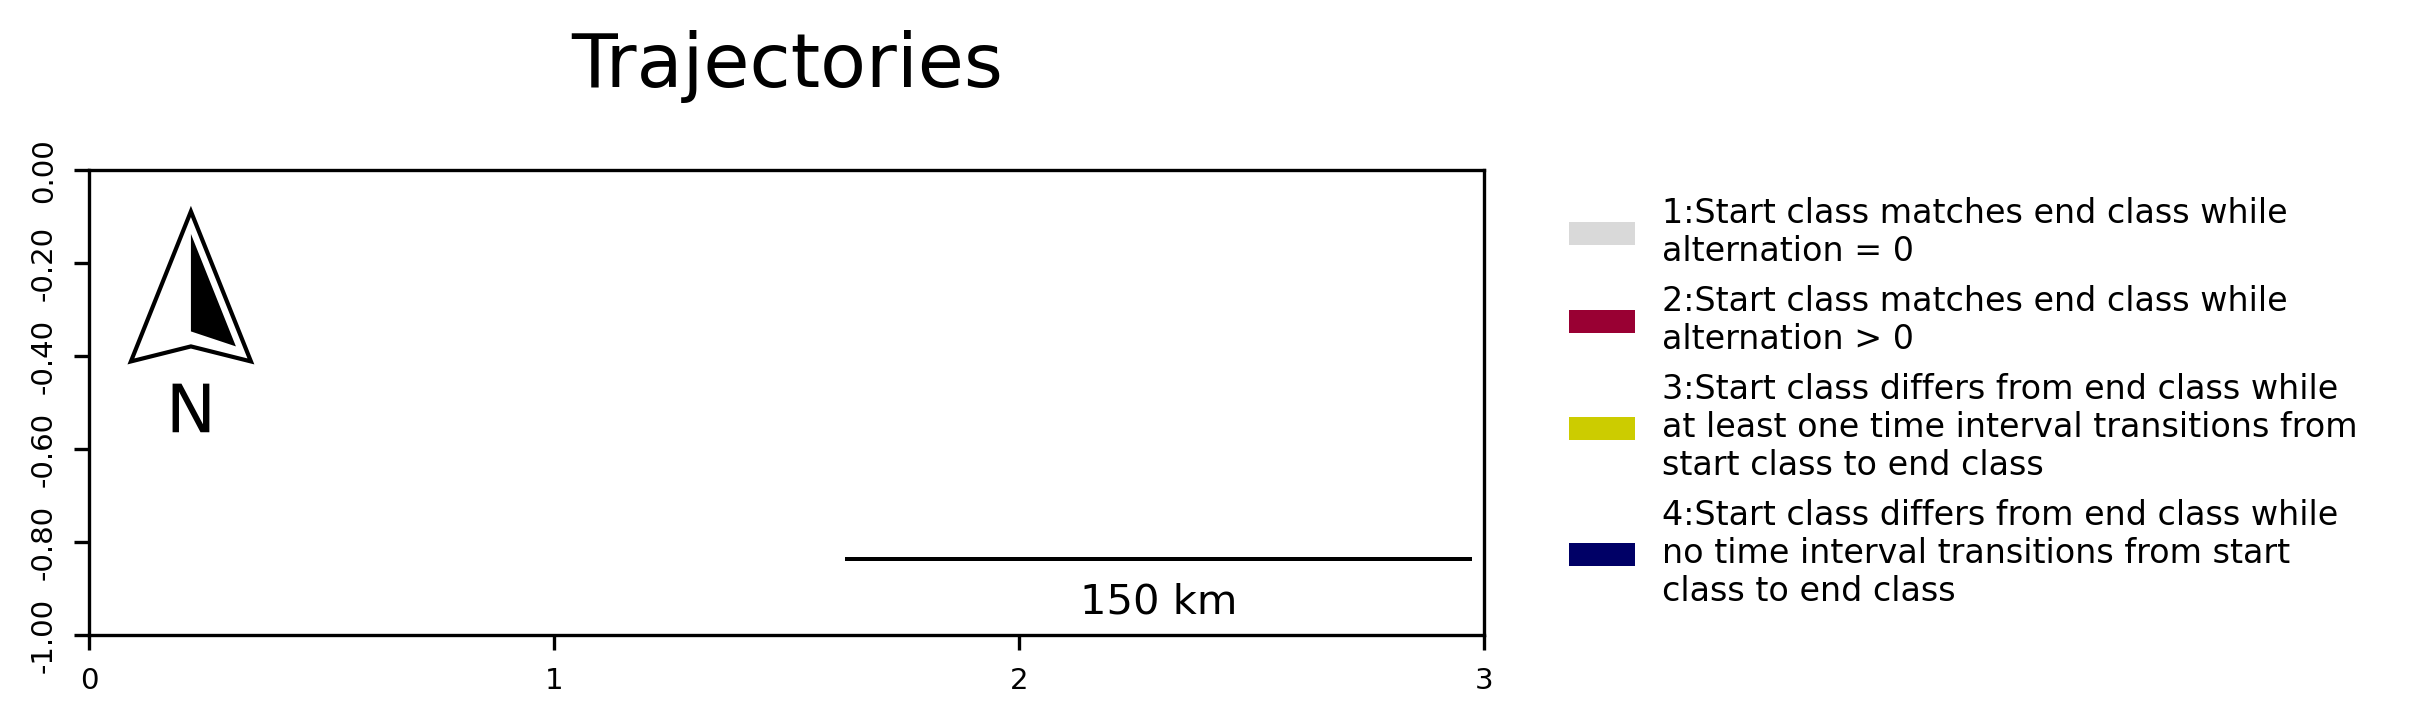

Trajectory map saved successfully to: /Users/antoniofonseca/Dataset/toydata/toydata1/map_trajectories.png


In [63]:
# 1) Input raster path
raster_path = os.path.join(
    output_path,
    "trajectory.tif",
)

# 2) Read raster and basic metadata
with rasterio.open(
    raster_path,
) as src:
    scale_factor = 0.5

    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor),
        ),
        resampling=rasterio.enums.Resampling.nearest,
    )

    left, bottom, right, top = src.bounds
    src_crs = src.crs
    transform = src.transform

# 3) Figure
fig, ax = plt.subplots(
    figsize=(
        6,
        8,
    ),
    dpi=300,
)

# 4) Colormap (categorical: 0–4)
cmap = ListedColormap(
    [
        "#ffffff",
        "#d9d9d9",
        "#990033",
        "#cccc00",
        "#000066",
    ],
)

# 5) Plot raster in original projection coordinates
ax.imshow(
    data,
    extent=[
        left,
        right,
        bottom,
        top,
    ],
    cmap=cmap,
    interpolation="none",
)

# 6) Legend
legend_elements = [
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#d9d9d9",
        label=(
            "1:Start class matches end class while\n"
            "alternation = 0"
        ),
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#990033",
        label=(
            "2:Start class matches end class while\n"
            "alternation > 0"
        ),
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#cccc00",
        label=(
            "3:Start class differs from end class while\n"
            "at least one time interval transitions from\n"
            "start class to end class"
        ),
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#000066",
        label=(
            "4:Start class differs from end class while\n"
            "no time interval transitions from start\n"
            "class to end class"
        ),
    ),
]
ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(
        1.02,
        0.5,
    ),
    frameon=False,
    fontsize=8,
    borderpad=1.2,
    handletextpad=0.8,
    columnspacing=2,
)

# 7) Cartographic elements (scale bar + north arrow)

# Compute approximate pixel size in meters for any CRS
if src_crs is not None and src_crs.is_projected:
    pixel_size_m = transform.a
else:
    from pyproj import Geod, CRS

    geod = Geod(
        ellps="WGS84",
    )
    crs_ll = CRS.from_epsg(
        4326,
    )

    if src_crs is not None and src_crs.to_string() != crs_ll.to_string():
        transformer_ll = Transformer.from_crs(
            src_crs,
            crs_ll,
            always_xy=True,
        )
    else:
        transformer_ll = None

    x_center = (left + right) / 2.0
    y_center = (bottom + top) / 2.0

    if transformer_ll is not None:
        lon_center, lat_center = transformer_ll.transform(
            x_center,
            y_center,
        )
        lon_right, _ = transformer_ll.transform(
            x_center + transform.a,
            y_center,
        )
    else:
        lon_center, lat_center = x_center, y_center
        lon_right = x_center + transform.a

    _, _, dist_m = geod.inv(
        lon_center,
        lat_center,
        lon_right,
        lat_center,
    )
    pixel_size_m = dist_m

scalebar = ScaleBar(
    dx=pixel_size_m / 1000.0,
    units="km",
    length_fraction=0.5,
    location="lower right",
    box_alpha=0.0,
    scale_formatter=lambda value, _: f"{int(value)} km",
)
ax.add_artist(
    scalebar,
)

north_arrow(
    ax,
    location="upper left",
    shadow=False,
    rotation={
        "degrees": 0,
    },
)

# 8) Axes styling
ax.set_title(
    "Trajectories",
    fontsize=18,
    pad=20,
)
ax.set_aspect(
    "equal",
)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=7,
    pad=4,
)
ax.xaxis.set_major_locator(
    plt.MaxNLocator(
        3,
    ),
)
ax.yaxis.set_major_locator(
    plt.MaxNLocator(
        6,
    ),
)

# Show y-axis coordinates on the left, vertically
from matplotlib.ticker import FuncFormatter

ax.yaxis.set_major_formatter(
    FuncFormatter(
        lambda y, pos: f"{y:.2f}",
    ),
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va="center",
)

# 9) Save
output_figure_path = os.path.join(
    output_path,
    "map_trajectories.png",
)
plt.savefig(
    output_figure_path,
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.5,
)
plt.show()

print(
    f"Trajectory map saved successfully to: {output_figure_path}",
)